# Google Drive Bağlantısı

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Modüllerin Kurulması ve Import Edilmesi

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

#Giriş

**Açıklama:**
Bu uygulama da bir grup çağrı merkezlerinden toplanılan çağrı kayıtlarından oluşturulan bir veri kümesinde, "Sentiment" olmak üzere hedef değişkeni tahmin ederek çağrı merkezlerinin performaslarını değerlendirmeyi amaçlayacağız.

#1) Veri Kümesinin Okunması

In [206]:
import pandas as pd

dataset = pd.read_csv('/content/drive/MyDrive/CallCenterAnalysis/CallCenter.csv')

print(dataset.head().to_string())

                         id       customer_name      sentiment  csat_score call_timestamp            reason         city           state      channel response_time  call duration in minutes     call_center
0  DKK-57076809-w-055481-fU    Analise Gairdner        Neutral         7.0     10/29/2020  Billing Question      Detroit        Michigan  Call-Center    Within SLA                        17  Los Angeles/CA
1  QGK-72219678-w-102139-KY    Crichton Kidsley  Very Positive         NaN     10/05/2020    Service Outage  Spartanburg  South Carolina      Chatbot    Within SLA                        23    Baltimore/MD
2  GYJ-30025932-A-023015-LD   Averill Brundrett       Negative         NaN     10/04/2020  Billing Question  Gainesville         Florida  Call-Center     Above SLA                        45  Los Angeles/CA
3  ZJI-96807559-i-620008-m7     Noreen Lafflina  Very Negative         1.0     10/17/2020  Billing Question     Portland          Oregon      Chatbot    Within SLA             

# Özniteliklerin Görselleştirilmesi

#2) Veri Ön İşleme Adımları

#2.1) Eksik Dağılım Analizi

#Eksik Verilerin İncelenmesi

                                            Column  Missing Count  \
csat_score                              csat_score          20670   
id                                              id              0   
customer_name                        customer_name              0   
sentiment                                sentiment              0   
call_timestamp                      call_timestamp              0   
reason                                      reason              0   
city                                          city              0   
state                                        state              0   
channel                                    channel              0   
response_time                        response_time              0   
call duration in minutes  call duration in minutes              0   
call_center                            call_center              0   

                          Missing Percentage  
csat_score                          62.74855  
id      

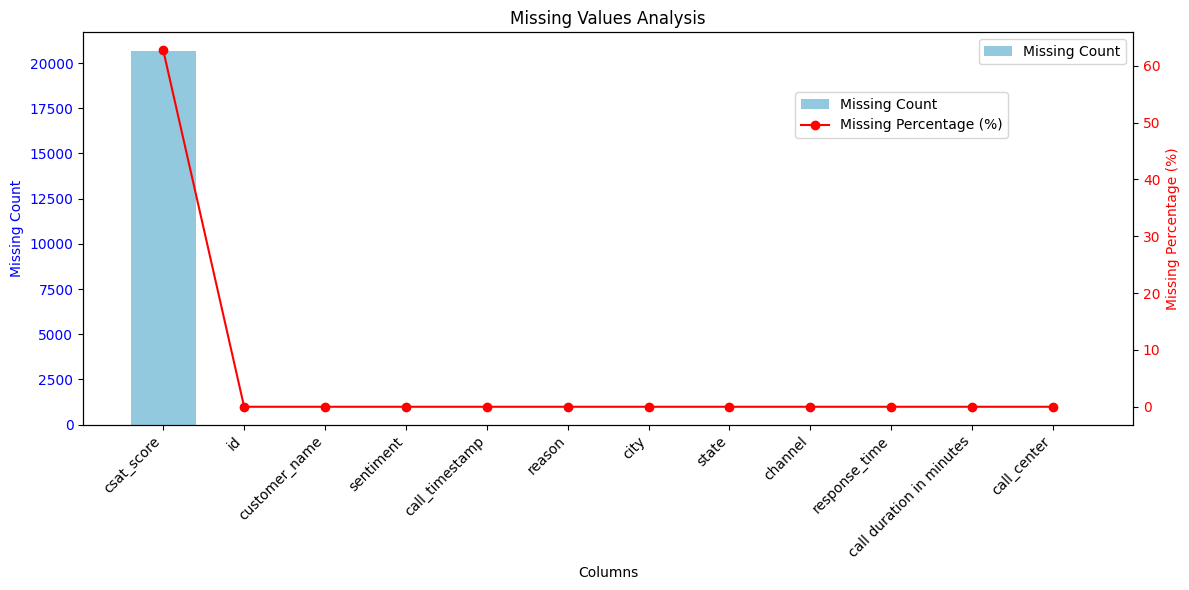

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_missing_values(data):
    """
    Verilen veri çerçevesindeki eksik değerleri analiz eder ve bir özet döndürür.

    Parametre:
        data (pd.DataFrame): Analiz edilecek veri çerçevesi.

    Dönüş:
        pd.DataFrame: Sütunlar için eksik değer sayısı ve yüzdesini içeren özet tablo.
    """
    missing_values = data.isnull().sum()
    missing_values_percentage = (missing_values / len(data)) * 100
    missing_values_summary = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Count': missing_values.values,
        'Missing Percentage': missing_values_percentage
    }).sort_values(by='Missing Percentage', ascending=False)

    return missing_values_summary

def visualize_missing_values(summary):
    """
    Eksik değer özet tablosunu görselleştirir.

    Parametre:
        summary (pd.DataFrame): Eksik değerlerin özeti (sütun, sayım, yüzdelik).
    """
    # Görselleştirme boyutlarını belirleme
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar grafiği: Eksik değerlerin sayısı
    sns.barplot(x='Column', y='Missing Count', data=summary, color='skyblue', ax=ax1, label='Missing Count')
    ax1.set_ylabel('Missing Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # İkincil eksen: Çizgi grafiği için
    ax2 = ax1.twinx()
    ax2.plot(summary['Column'], summary['Missing Percentage'], color='red', marker='o', label='Missing Percentage (%)')
    ax2.set_ylabel('Missing Percentage (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Eksenleri ve başlıkları ayarlama
    ax1.set_xticks(range(len(summary['Column'])))
    ax1.set_xticklabels(summary['Column'], rotation=45, ha='right')
    ax1.set_xlabel('Columns')
    plt.title('Missing Values Analysis')

    # Legendi manuel olarak ekle
    fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))

    # Görselleştirmeyi gösterme
    fig.tight_layout()
    plt.show()

# Kullanım
missing_values_summary = analyze_missing_values(dataset)
print(missing_values_summary)
visualize_missing_values(missing_values_summary)


# Eksik Verilere Yönelik Kural Tabanlı Yaklaşım

In [208]:
def fill_and_extract_by_sentiment_class(dataset, target_column, sentiment_column, sentiment_mapping, sentiment_class, count):
    """
    Belirtilen sentiment sınıfına göre eksik değerleri doldur ve count kadar veri döndür.

    Args:
    - dataset: Veri kümesi (pandas.DataFrame)
    - target_column: Eksik değerlerin doldurulacağı hedef sütun (string)
    - sentiment_column: Sentiment sınıfının bulunduğu sütun (string)
    - sentiment_mapping: Sentiment sınıfları ile değer aralıklarını eşleyen dict
    - sentiment_class: İlgili sentiment sınıfı (string)
    - count: Dönüştürmek istenilen örnek sayısı (int)

    Returns:
    - minor_dataset: Belirtilen sentiment sınıfından seçilen veri kümesi (pandas.DataFrame)
    """
    # Eksik csat_score değerlerini doldur
    for index, row in dataset.iterrows():
        sentiment = row[sentiment_column]  # Sentiment değerini al
        if pd.isna(row[target_column]) and sentiment in sentiment_mapping:  # Eksik değer için
            dataset.at[index, target_column] = random.choice(sentiment_mapping[sentiment])

    # Belirtilen sentiment sınıfına uygun verileri al
    if sentiment_class in sentiment_mapping:
        scores = sentiment_mapping[sentiment_class]  # İlgili sentiment'e karşılık gelen değerler
        subset = dataset[dataset[target_column].isin(scores)]  # İlgili sentiment verileri
        minor_dataset = subset.sample(n=min(len(subset), count), replace=False)  # Count kadar örnek al
    else:
        raise ValueError(f"Sentiment sınıfı '{sentiment_class}' geçerli değil.")

    return minor_dataset



def generate_combined_shuffled_dataset_dynamic_counts(dataset, target_column, sentiment_mapping, sentiment_classes, counts):
    """
    Her sentiment sınıfı için dinamik count ile minor dataset oluşturur, birleştirir ve karıştırır.

    Args:
    - dataset: Veri kümesi (pandas.DataFrame)
    - target_column: Eksik değerlerin doldurulacağı hedef sütun (string)
    - sentiment_mapping: Sentiment sınıfları ile değer aralıklarını eşleyen dict
    - sentiment_classes: İşlem yapılacak sentiment sınıfları listesi (list)
    - counts: Her sentiment sınıfı için seçilecek veri sayısını içeren dict veya list

    Returns:
    - shuffled_dataset: Birleştirilmiş ve rastgele karıştırılmış veri kümesi (pandas.DataFrame)
    """
    minor_datasets = []

    # Her sentiment sınıfı için minor dataset oluştur
    for sentiment_class in sentiment_classes:
        # Her sentiment sınıfı için uygun count değeri al
        count = counts[sentiment_class] if isinstance(counts, dict) else counts[sentiment_classes.index(sentiment_class)]

        # Veri setini oluştur
        minor_dataset = fill_and_extract_by_sentiment_class(
            dataset=dataset,
            target_column=target_column,
            sentiment_column="sentiment",
            sentiment_mapping=sentiment_mapping,
            sentiment_class=sentiment_class,
            count=count
        )
        minor_datasets.append(minor_dataset)

    # Minor datasetleri birleştir
    combined_dataset = pd.concat(minor_datasets, ignore_index=True)

    # Rastgele karıştır
    shuffled_dataset = combined_dataset.sample(frac=1).reset_index(drop=True)

    return shuffled_dataset

In [209]:
def visualize_csat_distribution_single(distribution, title="CSAT Score Distribution"):
    """
    Tek bir CSAT Score dağılımını görselleştir.

    Args:
    - distribution (pd.Series): Görselleştirilecek CSAT dağılımı.
    - title (str): Grafiğin başlığı.
    """
    plt.figure(figsize=(8, 6))
    plt.bar(distribution.index, distribution.values)
    plt.title(title)
    plt.xlabel("CSAT Score")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()


def handle_missing_data(df, threshold=0.25, numerical_strategy='mean', categorical_strategy='mode'):
    """
    Eksik verileri doldurmak için bir yöntem:
    - Sayısal kolonlarda eksik veri oranı verilen threshold'dan az ise belirtilen strateji ile doldurulur (default: 'mean').
    - Kategorik kolonlarda eksik veri oranı verilen threshold'dan az ise belirtilen strateji ile doldurulur (default: 'mode').
    - Eksik veri oranı threshold'dan büyükse ilgili satır silinir.

    Parametreler:
        df (pd.DataFrame): İşlenecek pandas veri çerçevesi
        threshold (float): Eksik veri oranı eşiği (default: 0.25)
        numerical_strategy (str): Sayısal kolonları doldurma stratejisi ('mean', 'median', 'constant')
        categorical_strategy (str): Kategorik kolonları doldurma stratejisi ('mode', 'constant')

    Döndürür:
        pd.DataFrame: Eksik verileri doldurulmuş veya satırları silinmiş veri çerçevesi
    """
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns

    for column in df.columns:
        missing_ratio = df[column].isnull().mean()
        if missing_ratio > 0 and missing_ratio < threshold:
            if column in numerical_vars:
                if numerical_strategy == 'mean':
                    fill_value = df[column].mean()
                elif numerical_strategy == 'median':
                    fill_value = df[column].median()
                elif numerical_strategy == 'constant':
                    fill_value = 0
                else:
                    raise ValueError("Invalid numerical_strategy. Choose from 'mean', 'median', 'constant'.")
                df[column].fillna(fill_value, inplace=True)
            elif column in categorical_vars:
                if categorical_strategy == 'mode':
                    fill_value = df[column].mode()[0]
                elif categorical_strategy == 'constant':
                    fill_value = 'missing'
                else:
                    raise ValueError("Invalid categorical_strategy. Choose from 'mode', 'constant'.")
                df[column].fillna(fill_value, inplace=True)
        elif missing_ratio >= threshold:

            dataset_copy = df.copy()
            dataset_current = df.dropna(subset=[column])
            dataset_null_csat_score = df[df['csat_score'].isna()]

            # Eksik olmayan satırlarda csat_score dağılımını analiz et
            csat_distribution = dataset_current['csat_score'].value_counts(normalize=True).sort_index()
            print("CSAT Score Distribution:\n", csat_distribution)

            # Sentiment'e göre csat_score atama işlemi
            sentiment_mapping = {
                'Very Negative': [1, 2],
                'Negative': [3, 4],
                'Neutral': [5, 6],
                'Positive': [7, 8],
                'Very Positive': [9, 10]
            }

            sentiment_classes = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

            counts = {
                "Very Negative": 1500,
                "Negative": 300,
                "Neutral": 400,
                "Positive": 300,
                "Very Positive": 1500
            }

            # Karışık veri kümesi oluştur
            will_be_concat_dataset = generate_combined_shuffled_dataset_dynamic_counts(
                dataset=dataset_null_csat_score,
                target_column="csat_score",
                sentiment_mapping=sentiment_mapping,
                sentiment_classes=sentiment_classes,
                counts=counts
            )

            final_combined_dataset = pd.concat([dataset_current, will_be_concat_dataset], ignore_index=True)
            final_combined_dataset = final_combined_dataset.sample(frac=1).reset_index(drop=True)

            # Güncel dağılım analizini yap
            updated_csat_distribution = final_combined_dataset['csat_score'].value_counts(normalize=True).sort_index()
            print("Updated CSAT Score Distribution:\n", updated_csat_distribution)


            # Güncellenmeden önceki CSAT dağılımı
            visualize_csat_distribution_single(distribution=csat_distribution, title="Before Update")

            # Güncellenmiş CSAT dağılımı
            visualize_csat_distribution_single(distribution=updated_csat_distribution, title="After Update")


            df = final_combined_dataset

    return df

# Gereksiz Kolonları Çıkarılması

In [210]:
def drop_unnecessary_columns(dataset, will_be_deleted_column_names):
  # gereksiz görülen kolonların silinmesi
  dataset = dataset.drop(columns=[col for col in dataset.columns if any(word in col for word in will_be_deleted_column_names)], errors='ignore')
  return dataset

# Tekrarlayan Satırların Çıkarılması

In [211]:
def clean_duplicate_records(dataset):
  dataset = dataset.drop_duplicates()
  return dataset

# Eksik Veri Analizi ve Dengeleme Analizi Sonucu Çıktıları Analiz Etme

In [212]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd

def plot_dataset_size_changes(step_sizes, step_names):
    """
    Veri kümesindeki eleman sayısındaki değişimleri tek bir histogram grafiğinde görselleştirir.

    Args:
    step_sizes (list): Her adım sonrası veri kümesindeki eleman sayıları
    step_names (list): Her adıma ait isimler
    """
    plt.figure(figsize=(10, 6))
    bars = plt.bar(step_names, step_sizes, color='blue', alpha=0.7)

    for bar, size in zip(bars, step_sizes):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(size), ha='center', va='bottom', fontsize=10)

    plt.title("Dataset Size Changes")
    plt.ylabel("Number of Records")
    plt.xlabel("Steps")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32941 entries, 0 to 32940
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        32941 non-null  object 
 1   customer_name             32941 non-null  object 
 2   sentiment                 32941 non-null  object 
 3   csat_score                12271 non-null  float64
 4   call_timestamp            32941 non-null  object 
 5   reason                    32941 non-null  object 
 6   city                      32941 non-null  object 
 7   state                     32941 non-null  object 
 8   channel                   32941 non-null  object 
 9   response_time             32941 non-null  object 
 10  call duration in minutes  32941 non-null  int64  
 11  call_center               32941 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 3.0+ MB
None
CSAT Score Distribution:
 csat_score
1.0     0.048488

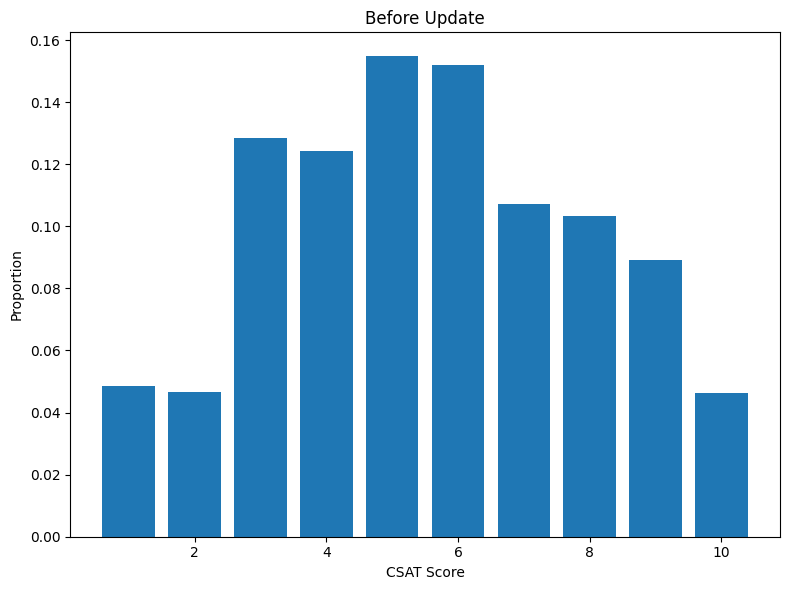

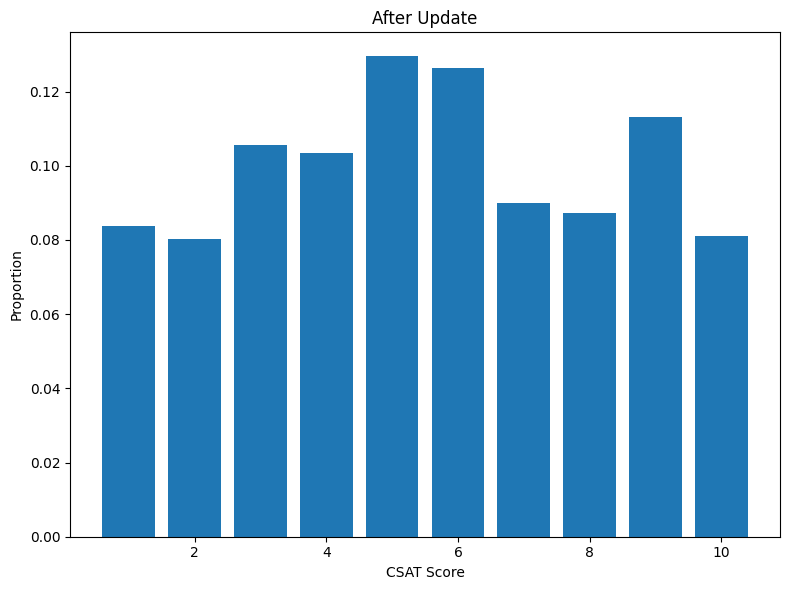

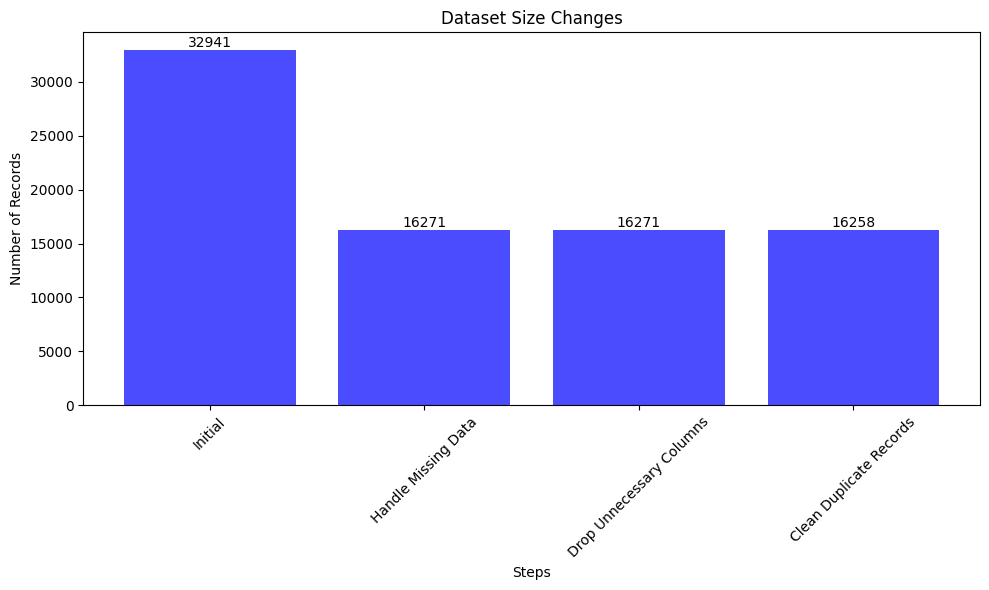

<class 'pandas.core.frame.DataFrame'>
Index: 16258 entries, 0 to 16270
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sentiment                 16258 non-null  object 
 1   csat_score                16258 non-null  float64
 2   call_timestamp            16258 non-null  object 
 3   reason                    16258 non-null  object 
 4   state                     16258 non-null  object 
 5   channel                   16258 non-null  object 
 6   response_time             16258 non-null  object 
 7   call duration in minutes  16258 non-null  int64  
 8   call_center               16258 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.2+ MB
None


In [213]:
# Örnek kullanım
step_sizes = []
step_names = []

# Başlangıç boyutunu ekle
step_sizes.append(len(dataset))
step_names.append("Initial")

# Adım 1: Eksik verileri doldurma
print(dataset.info())
dataset = handle_missing_data(dataset, 0.25, "mean", "mode")
step_sizes.append(len(dataset))
step_names.append("Handle Missing Data")

# Adım 2: Gereksiz sütunları kaldırma
dataset = drop_unnecessary_columns(dataset, will_be_deleted_column_names=["id", "customer_name", "city"])
step_sizes.append(len(dataset))
step_names.append("Drop Unnecessary Columns")

# Adım 3: Yinelenen kayıtları temizleme
dataset = clean_duplicate_records(dataset)
step_sizes.append(len(dataset))
step_names.append("Clean Duplicate Records")

# Eleman sayısındaki değişimi görselleştir
plot_dataset_size_changes(step_sizes, step_names)

print(dataset.info())

In [214]:
print(dataset.head(50).to_string())

        sentiment  csat_score call_timestamp            reason           state      channel response_time  call duration in minutes     call_center
0         Neutral         7.0     10/30/2020    Service Outage         Alabama      Chatbot    Within SLA                        14    Baltimore/MD
1         Neutral         6.0     10/06/2020  Billing Question      California      Chatbot     Below SLA                        19    Baltimore/MD
2         Neutral         5.0     10/04/2020    Service Outage         Arizona          Web    Within SLA                         7  Los Angeles/CA
3   Very Negative         1.0     10/13/2020  Billing Question        Nebraska  Call-Center    Within SLA                        24    Baltimore/MD
4         Neutral         6.0     10/12/2020  Billing Question            Iowa          Web     Below SLA                        23  Los Angeles/CA
5        Negative         5.0     10/09/2020  Billing Question        New York          Web     Below SLA       

# Mevcut Kolonlardan Yeni Kolonlar Üretilmesi

# Çağrı Merkezlerine göre Günlük Toplam Çağrı Sayısı Verilerini Elde Etme



In [215]:
def add_daily_call_count(dataset):
    """
    Veri kümesine her çağrı merkezi için günlük toplam çağrı sayısını ekler.

    Parametreler:
        dataset (pd.DataFrame): Çağrı merkezi verilerini içeren veri kümesi.

    Dönüş:
        pd.DataFrame: Günlük çağrı sayısını eklenmiş veri kümesi.
    """
    # Tarihi datetime formatına çevir
    dataset['call_date'] = pd.to_datetime(dataset['call_timestamp'], format='%m/%d/%Y')

    # Günlük çağrı sayısını hesapla (çağrı merkezi bazında)
    daily_calls_per_center = dataset.groupby(['call_date', 'call_center']).size().reset_index(name='daily_call_count')

    # Orijinal veri kümesine daily_call_count sütununu ekle
    dataset = dataset.merge(daily_calls_per_center, on=['call_date', 'call_center'], how='left')

    return dataset


dataset = add_daily_call_count(dataset)

print(dataset.head(20).to_string())

        sentiment  csat_score call_timestamp            reason          state      channel response_time  call duration in minutes     call_center  call_date  daily_call_count
0         Neutral         7.0     10/30/2020    Service Outage        Alabama      Chatbot    Within SLA                        14    Baltimore/MD 2020-10-30               182
1         Neutral         6.0     10/06/2020  Billing Question     California      Chatbot     Below SLA                        19    Baltimore/MD 2020-10-06               177
2         Neutral         5.0     10/04/2020    Service Outage        Arizona          Web    Within SLA                         7  Los Angeles/CA 2020-10-04               221
3   Very Negative         1.0     10/13/2020  Billing Question       Nebraska  Call-Center    Within SLA                        24    Baltimore/MD 2020-10-13               176
4         Neutral         6.0     10/12/2020  Billing Question           Iowa          Web     Below SLA                

# Tarih Kolonundan Haftanın Günleri Kolonunun Elde Edilmesi

In [216]:
def add_weekday_column(dataset):
    """
    Veri kümesine haftanın günü bilgisi ekler.

    Parametreler:
        dataset (pd.DataFrame): Çağrı merkezi verilerini içeren veri kümesi.

    Dönüş:
        pd.DataFrame: Haftanın günü sütunu eklenmiş veri kümesi.
    """
    # Haftanın gününü çıkart
    dataset['weekday'] = dataset['call_date'].dt.day_name()
    return dataset

dataset = add_weekday_column(dataset)
print(dataset.head(20).to_string())

        sentiment  csat_score call_timestamp            reason          state      channel response_time  call duration in minutes     call_center  call_date  daily_call_count    weekday
0         Neutral         7.0     10/30/2020    Service Outage        Alabama      Chatbot    Within SLA                        14    Baltimore/MD 2020-10-30               182     Friday
1         Neutral         6.0     10/06/2020  Billing Question     California      Chatbot     Below SLA                        19    Baltimore/MD 2020-10-06               177    Tuesday
2         Neutral         5.0     10/04/2020    Service Outage        Arizona          Web    Within SLA                         7  Los Angeles/CA 2020-10-04               221     Sunday
3   Very Negative         1.0     10/13/2020  Billing Question       Nebraska  Call-Center    Within SLA                        24    Baltimore/MD 2020-10-13               176    Tuesday
4         Neutral         6.0     10/12/2020  Billing Question   

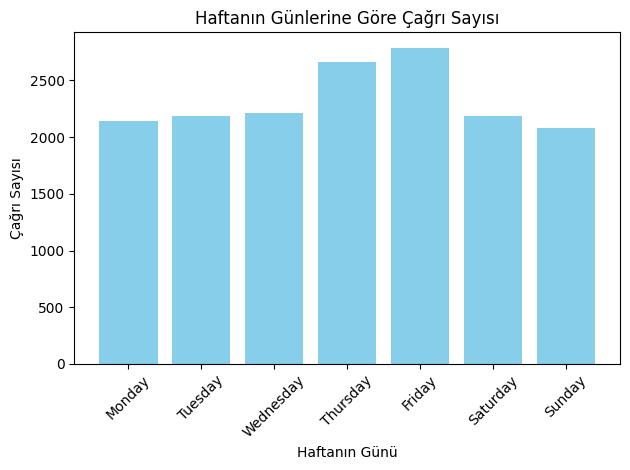

In [217]:
def plot_weekday_calls(dataset):
    """
    Haftanın günlerine göre çağrı sayısını hesaplar ve bir çubuk grafik ile görselleştirir.

    Parametreler:
        dataset (pd.DataFrame): Haftanın günü bilgisi içeren veri kümesi. 'weekday' sütununu barındırmalıdır.

    Dönüş:
        None: Grafiği çizer ve gösterir.
    """
    # Haftanın günlerine göre çağrı sayısını hesapla
    weekday_calls = dataset.groupby('weekday').size().reset_index(name='call_count')

    # Haftanın günlerini sıralamak için
    weekday_calls['weekday'] = pd.Categorical(weekday_calls['weekday'],
                                              categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                              ordered=True)
    weekday_calls = weekday_calls.sort_values('weekday')

    # Çubuk grafik ile görselleştirme
    plt.bar(weekday_calls['weekday'], weekday_calls['call_count'], color='skyblue')
    plt.title('Haftanın Günlerine Göre Çağrı Sayısı')
    plt.xlabel('Haftanın Günü')
    plt.ylabel('Çağrı Sayısı')
    plt.xticks(rotation=45)  # Haftanın günlerini eğik gösterir
    plt.tight_layout()  # Grafik elemanlarının sığmasını sağlar
    plt.show()


plot_weekday_calls(dataset)

# Haftanın Günleri Kolonundan Haftanın Günlerine göre Ortalama Çağrı Sayısı Verilerinin Elde Edilmesi

In [218]:
def add_weekday_average_calls(dataset):
    """
    Her çağrı merkezi için haftanın günlerine göre ortalama çağrı sayısını hesaplar ve veri kümesine ekler.

    Parametreler:
        dataset (pd.DataFrame): Haftanın günü ('weekday') ve çağrı merkezi ('call_center') bilgilerini içeren veri kümesi.

    Dönüş:
        pd.DataFrame: Haftanın günlerine göre ortalama çağrı sayısını içeren bir sütun eklenmiş veri kümesi.
    """
    # Haftanın gününe ve çağrı merkezine göre ortalama günlük çağrı sayısını hesapla
    weekday_avg_calls = (
        dataset.groupby(['call_center', 'weekday'])['daily_call_count']
        .mean()
        .reset_index(name='weekday_avg_calls')
    )

    # Orijinal veri kümesine bu ortalama değerleri ekle
    dataset = dataset.merge(
        weekday_avg_calls, on=['call_center', 'weekday'], how='left'
    )

    return dataset

dataset = add_weekday_average_calls(dataset)

print(dataset.head(20).to_string())

        sentiment  csat_score call_timestamp            reason          state      channel response_time  call duration in minutes     call_center  call_date  daily_call_count    weekday  weekday_avg_calls
0         Neutral         7.0     10/30/2020    Service Outage        Alabama      Chatbot    Within SLA                        14    Baltimore/MD 2020-10-30               182     Friday         182.779978
1         Neutral         6.0     10/06/2020  Billing Question     California      Chatbot     Below SLA                        19    Baltimore/MD 2020-10-06               177    Tuesday         183.964578
2         Neutral         5.0     10/04/2020    Service Outage        Arizona          Web    Within SLA                         7  Los Angeles/CA 2020-10-04               221     Sunday         217.941312
3   Very Negative         1.0     10/13/2020  Billing Question       Nebraska  Call-Center    Within SLA                        24    Baltimore/MD 2020-10-13               176 

# Haftanın Günü (WeekDay) Kolonu ve Channel Kolonlarına göre Çağrının Yapıldığı Gün için Kanalların Çağrı Yüklerinin Elde Edilmesi

In [219]:
def add_channel_percentage_load(dataset):
    """
    Veri kümesine her `channel` için haftanın belirli bir günü toplam çağrılara göre yüzdesel yük ekler.

    Parametreler:
        dataset (pd.DataFrame): Veri kümesi.

    Dönüş:
        pd.DataFrame: Her bir kanal için yüzdesel yük sütunları eklenmiş veri kümesi.
    """
    # Her haftanın günü ve kanal için toplam çağrı sayısını hesapla
    channel_totals = dataset.groupby(['weekday', 'channel'])['daily_call_count'].sum().unstack(fill_value=0)

    # Haftanın gününe göre toplam çağrı sayısını bul
    weekday_totals = channel_totals.sum(axis=1)

    # Her kanalın yüzdesel yükünü hesapla
    channel_percentages = (channel_totals.T / weekday_totals).T * 100  # Yüzdelik hesap

    # Yüzdesel yüklerin sütun isimlerini ayarla
    channel_percentages = channel_percentages.add_suffix('_percent_load').reset_index()

    # Orijinal veri kümesine yüzdesel yük sütunlarını ekle
    dataset = dataset.merge(channel_percentages, on='weekday', how='left')

    return dataset

dataset = add_channel_percentage_load(dataset)

print(dataset.head(20).to_string())

        sentiment  csat_score call_timestamp            reason          state      channel response_time  call duration in minutes     call_center  call_date  daily_call_count    weekday  weekday_avg_calls  Call-Center_percent_load  Chatbot_percent_load  Email_percent_load  Web_percent_load
0         Neutral         7.0     10/30/2020    Service Outage        Alabama      Chatbot    Within SLA                        14    Baltimore/MD 2020-10-30               182     Friday         182.779978                 30.058362             27.191955           23.224558         19.525125
1         Neutral         6.0     10/06/2020  Billing Question     California      Chatbot     Below SLA                        19    Baltimore/MD 2020-10-06               177    Tuesday         183.964578                 33.233209             25.771060           22.561266         18.434464
2         Neutral         5.0     10/04/2020    Service Outage        Arizona          Web    Within SLA                    

In [220]:
print(dataset.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16258 entries, 0 to 16257
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sentiment                 16258 non-null  object        
 1   csat_score                16258 non-null  float64       
 2   call_timestamp            16258 non-null  object        
 3   reason                    16258 non-null  object        
 4   state                     16258 non-null  object        
 5   channel                   16258 non-null  object        
 6   response_time             16258 non-null  object        
 7   call duration in minutes  16258 non-null  int64         
 8   call_center               16258 non-null  object        
 9   call_date                 16258 non-null  datetime64[ns]
 10  daily_call_count          16258 non-null  int64         
 11  weekday                   16258 non-null  object        
 12  weekday_avg_calls 

# Gereksiz Kolonlar Çıkartılıyor ve Düzeltiliyor

In [221]:
# kolon isimleri güncelleniyor
dataset = dataset.rename(columns={'call duration in minutes': 'call_duration_in_minutes'})

#kullanılması planlanmayan ya da zaten kullanılmış kolonlar
dataset = drop_unnecessary_columns(dataset, will_be_deleted_column_names=["call_timestamp", "state"])

print(dataset.info())
print(dataset.head(20).to_string())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16258 entries, 0 to 16257
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sentiment                 16258 non-null  object        
 1   csat_score                16258 non-null  float64       
 2   reason                    16258 non-null  object        
 3   channel                   16258 non-null  object        
 4   response_time             16258 non-null  object        
 5   call_duration_in_minutes  16258 non-null  int64         
 6   call_center               16258 non-null  object        
 7   call_date                 16258 non-null  datetime64[ns]
 8   daily_call_count          16258 non-null  int64         
 9   weekday                   16258 non-null  object        
 10  weekday_avg_calls         16258 non-null  float64       
 11  Call-Center_percent_load  16258 non-null  float64       
 12  Chatbot_percent_lo

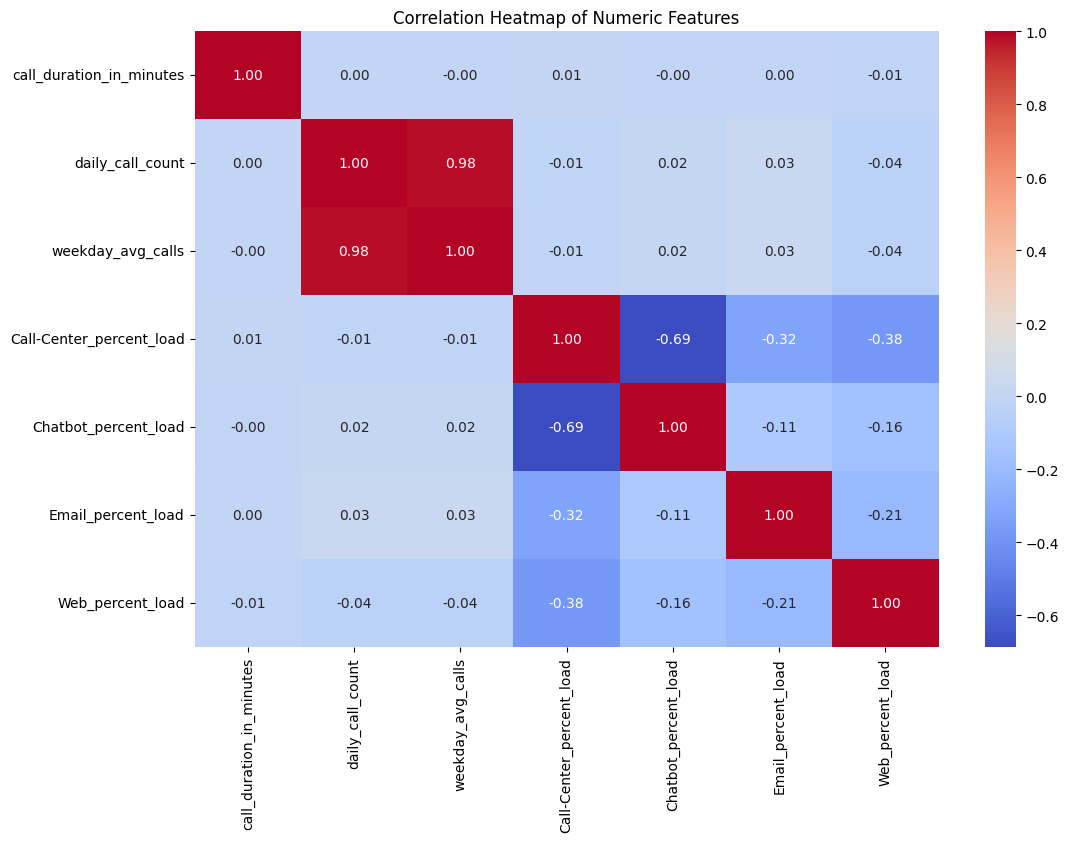

Variance of Numeric Features:
Email_percent_load             0.445818
Web_percent_load               0.596998
Chatbot_percent_load           1.080178
Call-Center_percent_load       1.490207
call_duration_in_minutes     139.079996
weekday_avg_calls           3734.388105
daily_call_count            3882.867244
dtype: float64


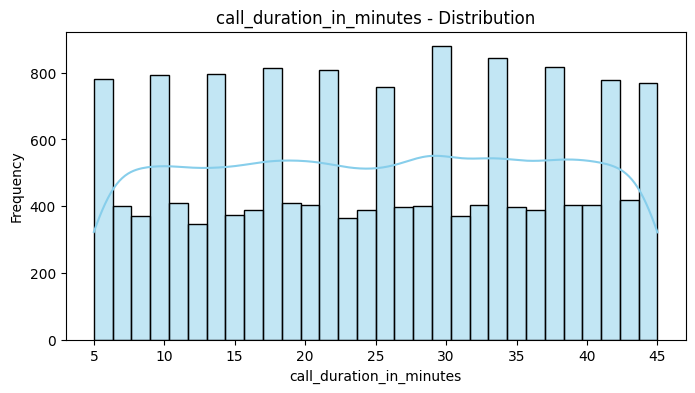

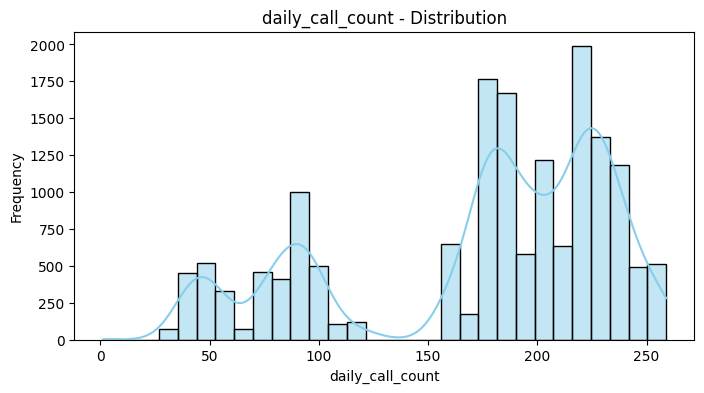

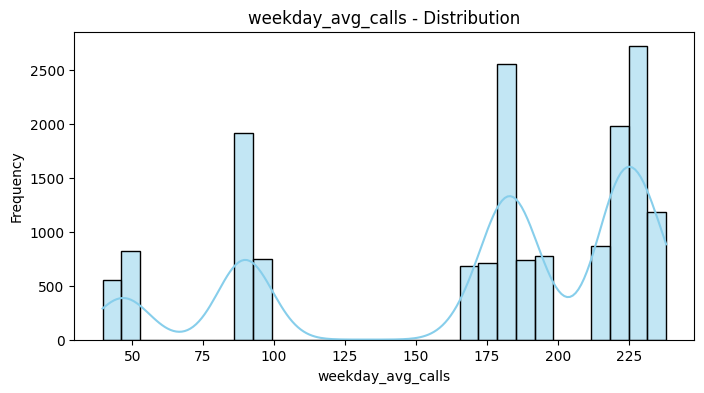

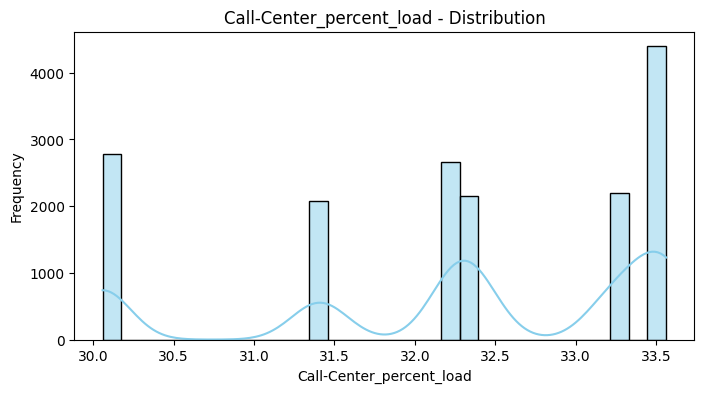

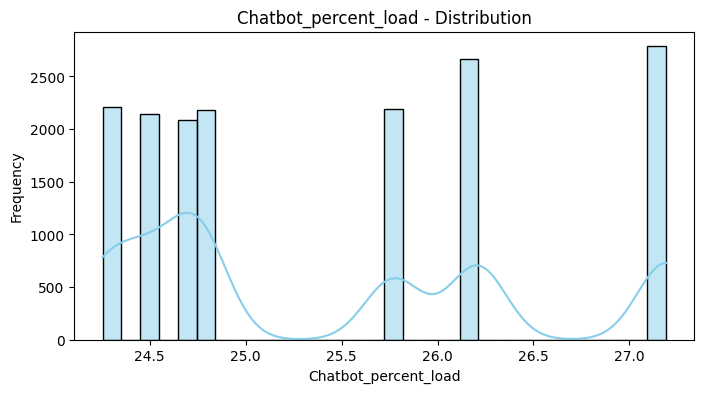

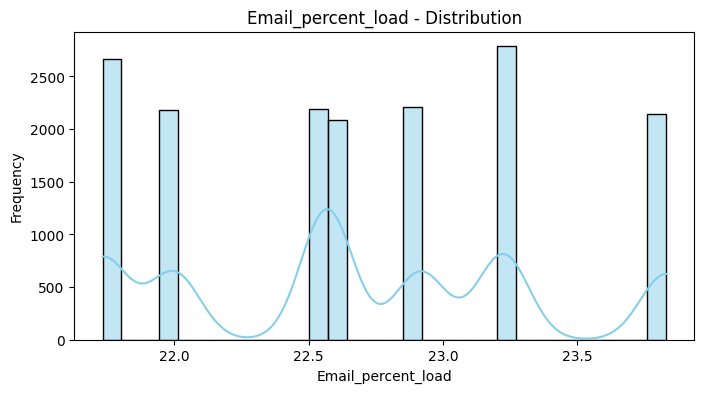

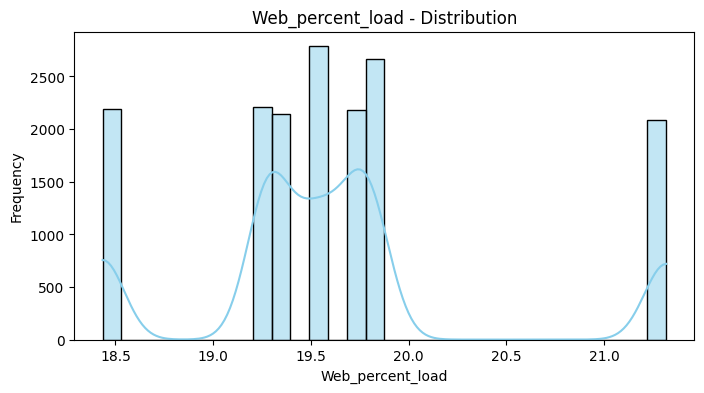

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


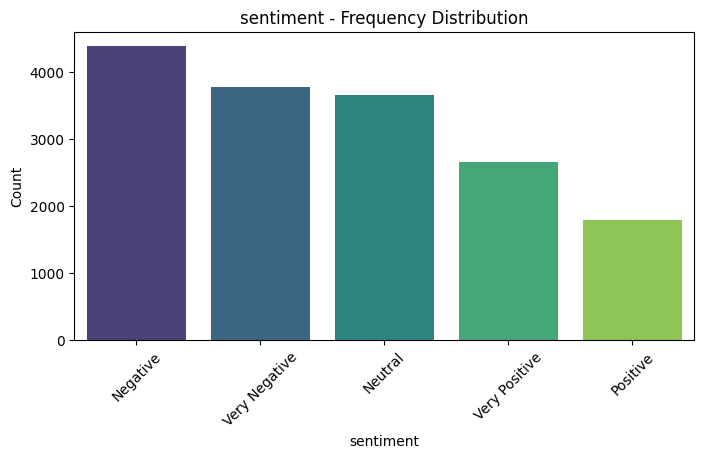

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


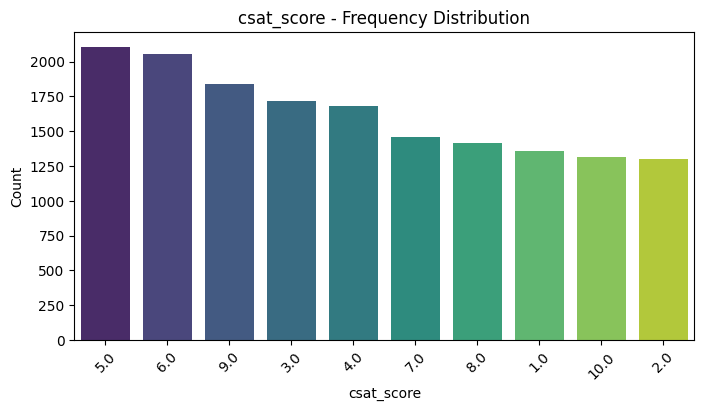

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


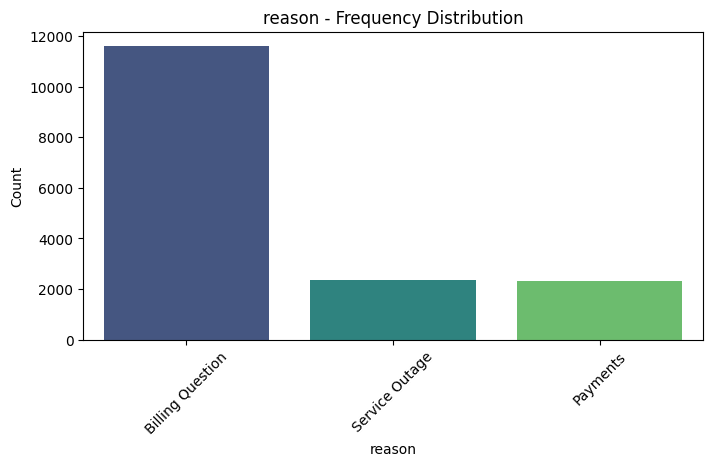

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


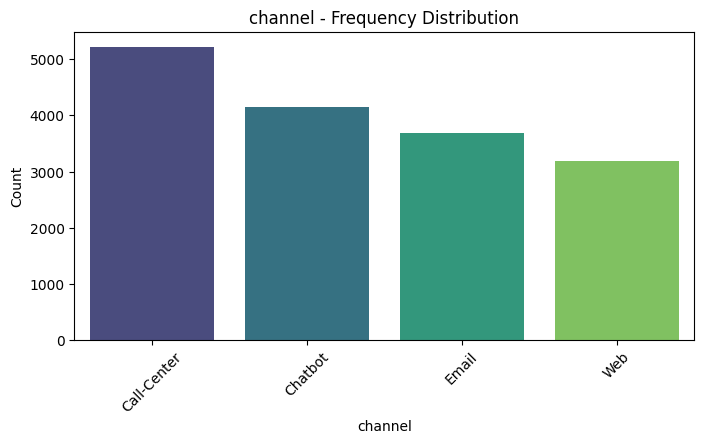

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


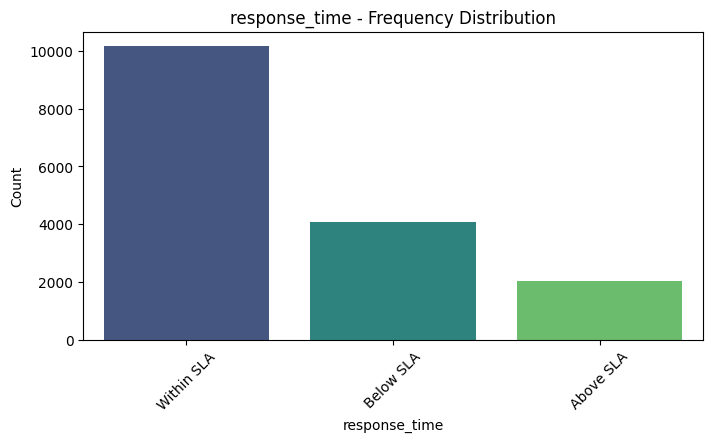

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


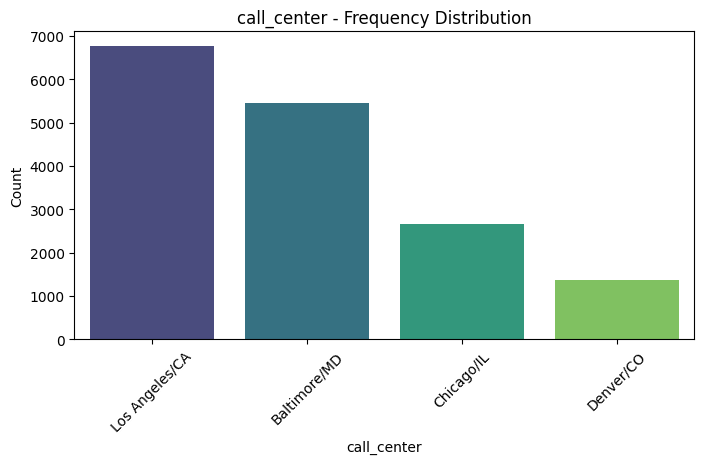

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


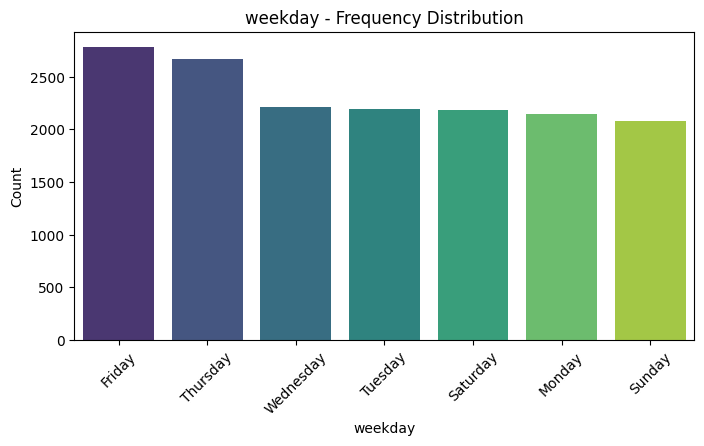

<ipython-input-222-02c7c91f24f6>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importances, palette='coolwarm')


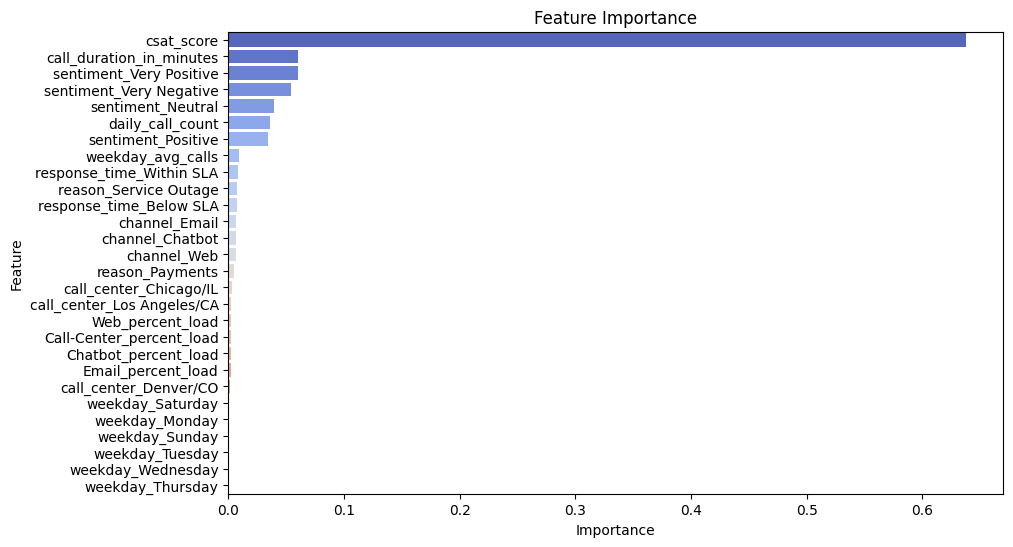

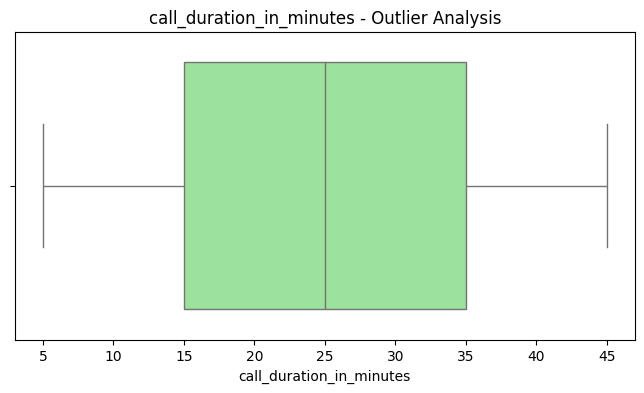

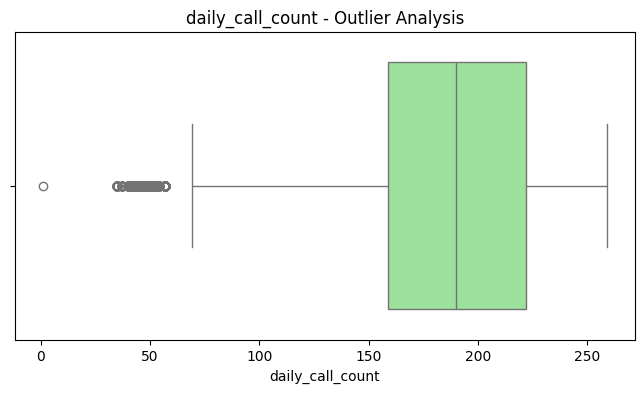

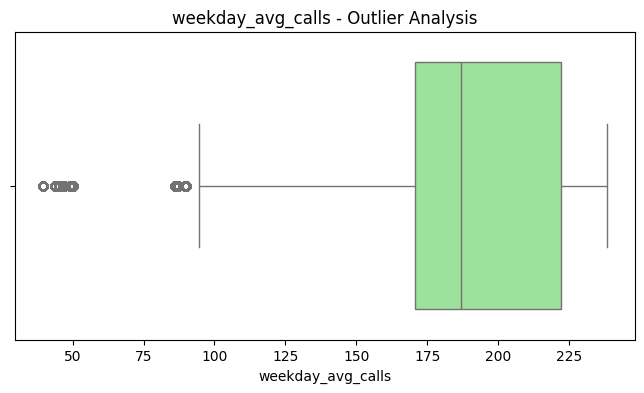

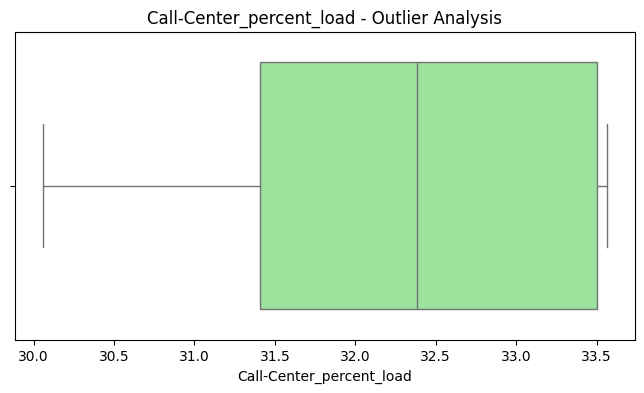

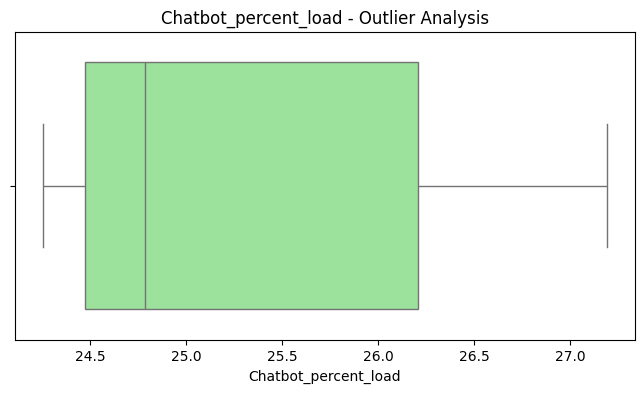

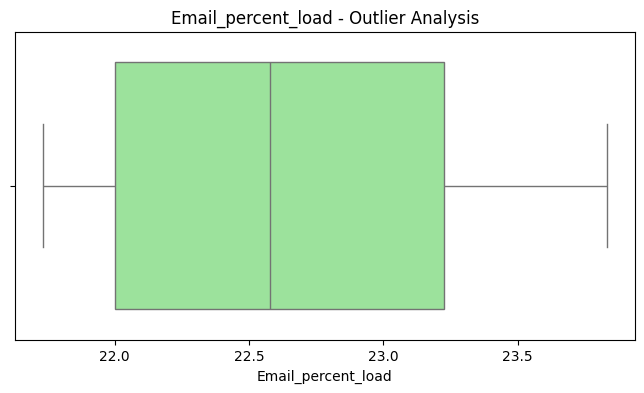

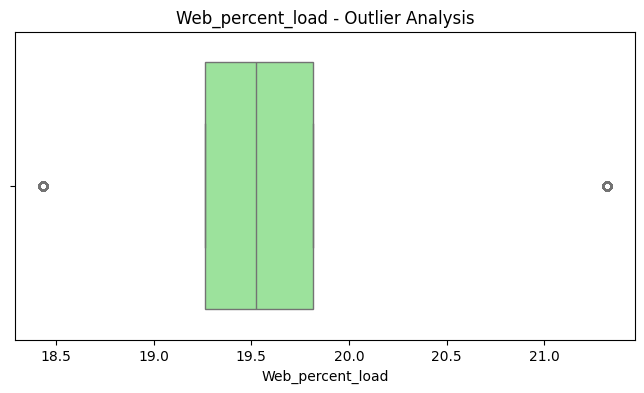

Missing Data (%):
sentiment                   0.0
csat_score                  0.0
reason                      0.0
channel                     0.0
response_time               0.0
call_duration_in_minutes    0.0
call_center                 0.0
call_date                   0.0
daily_call_count            0.0
weekday                     0.0
weekday_avg_calls           0.0
Call-Center_percent_load    0.0
Chatbot_percent_load        0.0
Email_percent_load          0.0
Web_percent_load            0.0
dtype: float64


In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

numeric_columns = ["call_duration_in_minutes", "daily_call_count", "weekday_avg_calls", "Call-Center_percent_load", "Chatbot_percent_load", "Email_percent_load", "Web_percent_load"]
categorical_columns = ["sentiment", "csat_score", "reason", "channel", "response_time", "call_center", "weekday"]


# 1. Korelasyon Analizi

def plot_correlation_heatmap(dataset, numeric_columns):
    plt.figure(figsize=(12, 8))
    sns.heatmap(dataset[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()

# 2. Varyans Analizi

def calculate_variances(dataset, numeric_columns):
    variances = dataset[numeric_columns].var()
    print("Variance of Numeric Features:")
    print(variances.sort_values())
    return variances

# 3. Sayısal Kolonların Dağılımı

def plot_numeric_distributions(dataset, numeric_columns):
    for col in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(dataset[col], kde=True, bins=30, color='skyblue')
        plt.title(f'{col} - Distribution')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

# 4. Kategorik Kolonların Dağılımı

def plot_categorical_distributions(dataset, categorical_columns):
    for col in categorical_columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)
        plt.title(f'{col} - Frequency Distribution')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# 5. Feature Importance Analizi

def calculate_feature_importance(dataset, numeric_columns, categorical_columns, target_column):
    X = pd.get_dummies(dataset[numeric_columns + categorical_columns], drop_first=True)
    y = dataset[target_column]

    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
    importances = importances.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importances, palette='coolwarm')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    return importances

# 6. Outlier Analizi

def plot_outlier_analysis(dataset, numeric_columns):
    for col in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=dataset[col], color='lightgreen')
        plt.title(f'{col} - Outlier Analysis')
        plt.xlabel(col)
        plt.show()

# 7. Eksik Veri Analizi

def calculate_missing_data(dataset):
    missing = dataset.isnull().mean() * 100
    print("Missing Data (%):")
    print(missing.sort_values(ascending=False))
    return missing


# Korelasyon analizi
plot_correlation_heatmap(dataset, numeric_columns)

# Varyans analizi
variances = calculate_variances(dataset, numeric_columns)

# Sayısal kolonların dağılımı
plot_numeric_distributions(dataset, numeric_columns)

# Kategorik kolonların dağılımı
plot_categorical_distributions(dataset, categorical_columns)

# Özellik önemi analizi (Hedef değişkeni belirtmeyi unutmayın!)
target_column = "csat_score"
feature_importances = calculate_feature_importance(dataset, numeric_columns, categorical_columns, target_column)

# Aykırı değer analizi
plot_outlier_analysis(dataset, numeric_columns)

# Eksik veri analizi
missing_data = calculate_missing_data(dataset)


In [223]:
print(dataset.info())
print(dataset.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16258 entries, 0 to 16257
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sentiment                 16258 non-null  object        
 1   csat_score                16258 non-null  float64       
 2   reason                    16258 non-null  object        
 3   channel                   16258 non-null  object        
 4   response_time             16258 non-null  object        
 5   call_duration_in_minutes  16258 non-null  int64         
 6   call_center               16258 non-null  object        
 7   call_date                 16258 non-null  datetime64[ns]
 8   daily_call_count          16258 non-null  int64         
 9   weekday                   16258 non-null  object        
 10  weekday_avg_calls         16258 non-null  float64       
 11  Call-Center_percent_load  16258 non-null  float64       
 12  Chatbot_percent_lo

# Gereksiz Kolonların Çıkartılması

In [224]:
#kullanılması planlanmayan ya da zaten kullanılmış kolonlar
def drop_unnecessary_matched_columns(dataset, will_be_deleted_column_names):
    # Sadece tam eşleşme ile kolon silme
    dataset = dataset.drop(columns=[col for col in dataset.columns if col in will_be_deleted_column_names], errors='ignore')
    return dataset


dataset = drop_unnecessary_matched_columns(dataset, will_be_deleted_column_names=["weekday", "call_center", "Email_percent_load"])

In [225]:
print(dataset.info())
print(dataset.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16258 entries, 0 to 16257
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sentiment                 16258 non-null  object        
 1   csat_score                16258 non-null  float64       
 2   reason                    16258 non-null  object        
 3   channel                   16258 non-null  object        
 4   response_time             16258 non-null  object        
 5   call_duration_in_minutes  16258 non-null  int64         
 6   call_date                 16258 non-null  datetime64[ns]
 7   daily_call_count          16258 non-null  int64         
 8   weekday_avg_calls         16258 non-null  float64       
 9   Call-Center_percent_load  16258 non-null  float64       
 10  Chatbot_percent_load      16258 non-null  float64       
 11  Web_percent_load          16258 non-null  float64       
dtypes: datetime64[ns](

# Tekrar Analiz

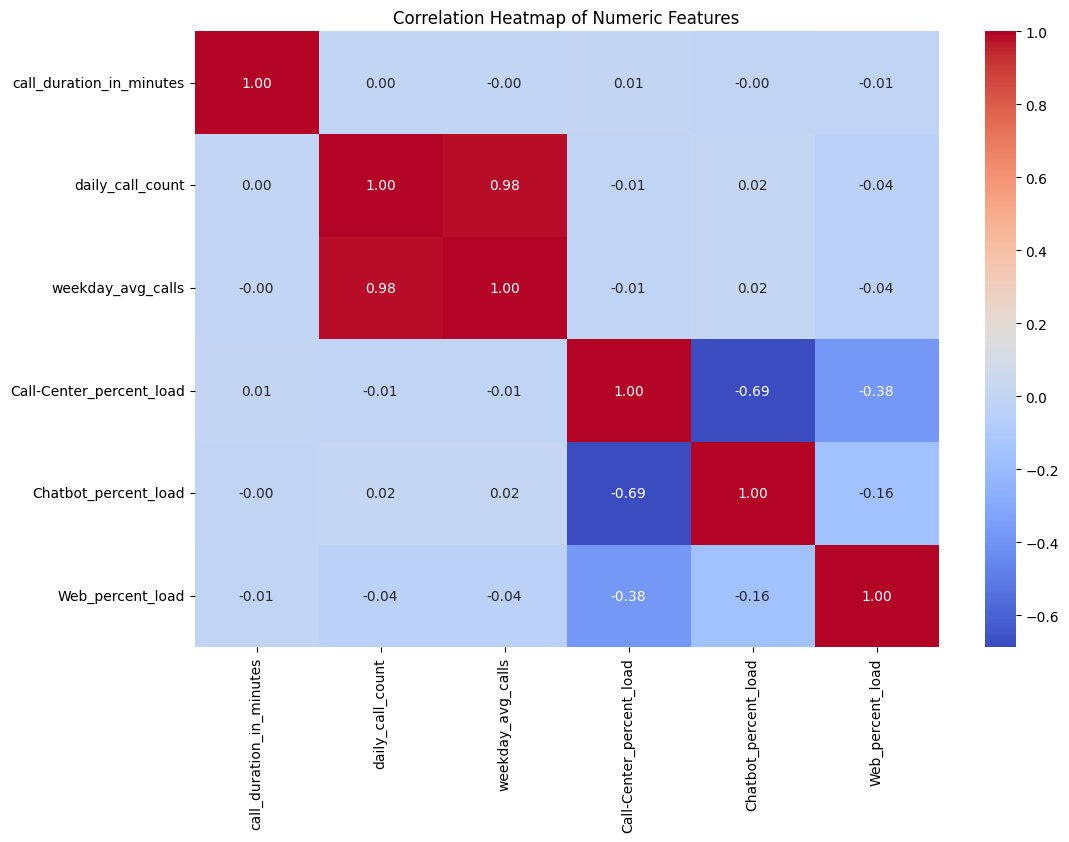

Variance of Numeric Features:
Web_percent_load               0.596998
Chatbot_percent_load           1.080178
Call-Center_percent_load       1.490207
call_duration_in_minutes     139.079996
weekday_avg_calls           3734.388105
daily_call_count            3882.867244
dtype: float64


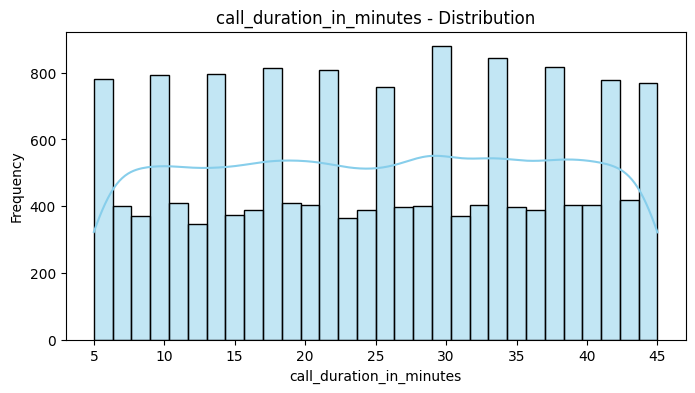

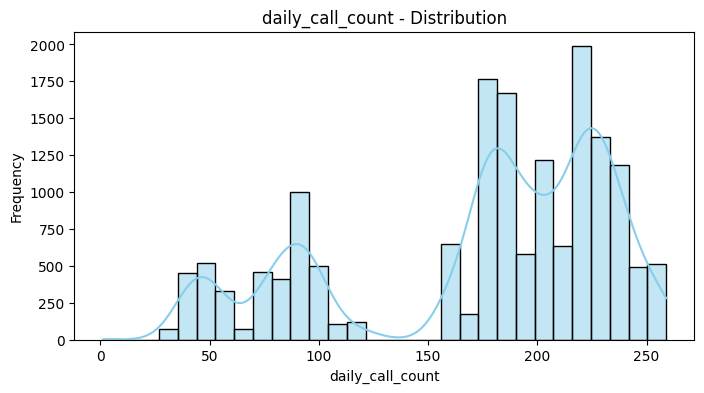

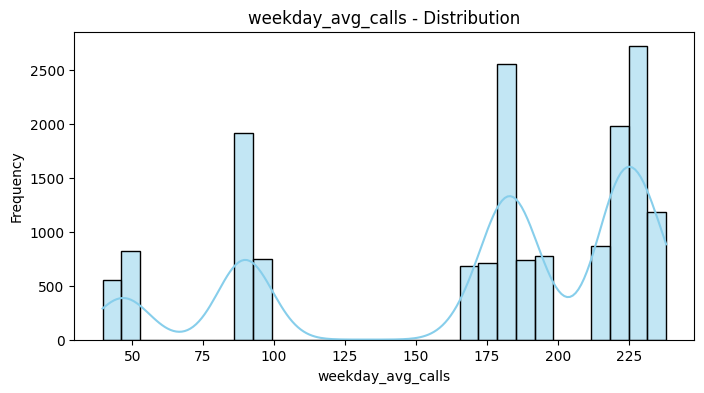

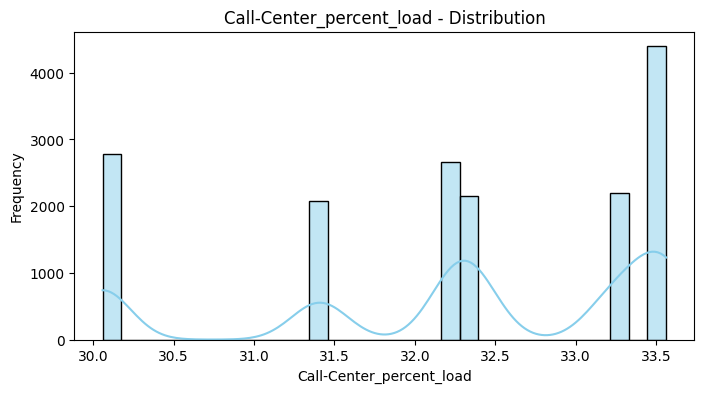

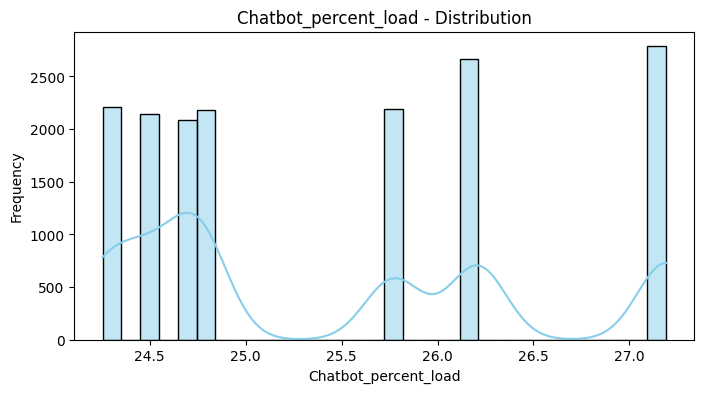

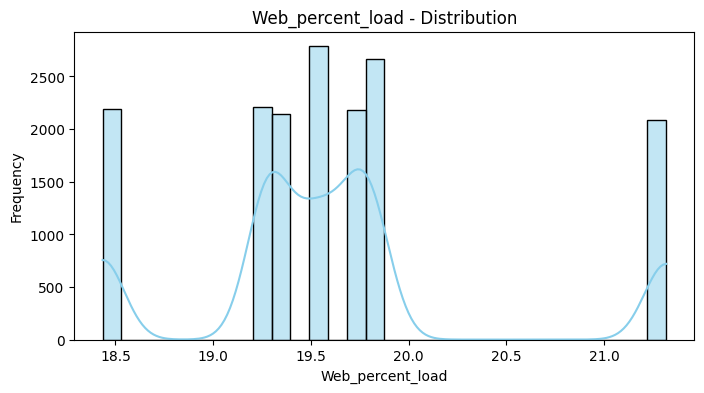

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


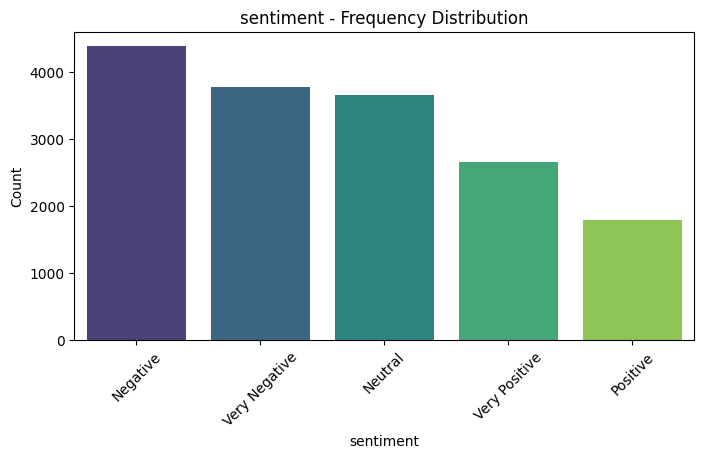

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


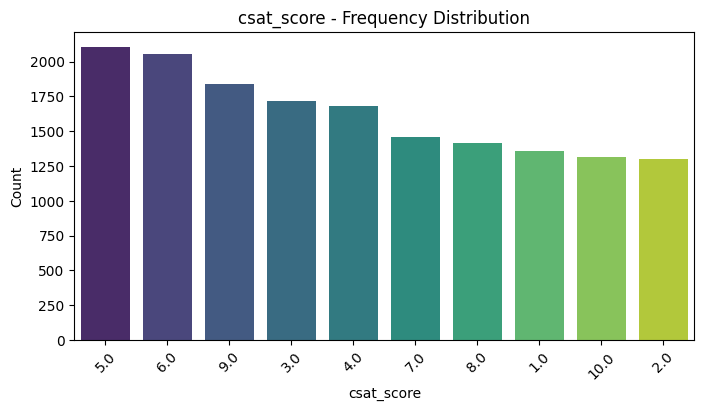

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


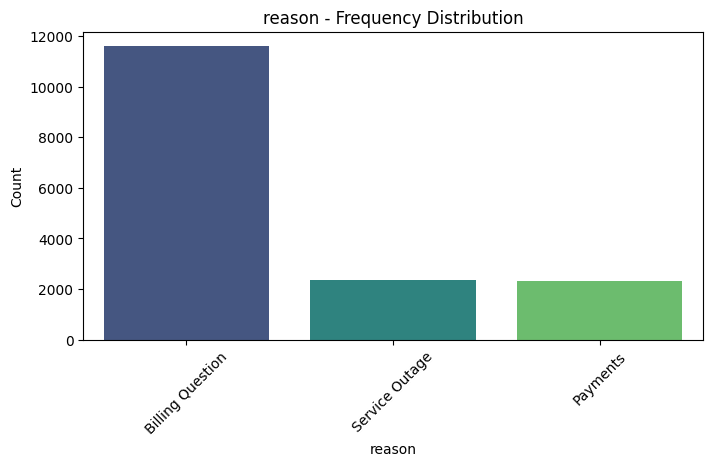

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


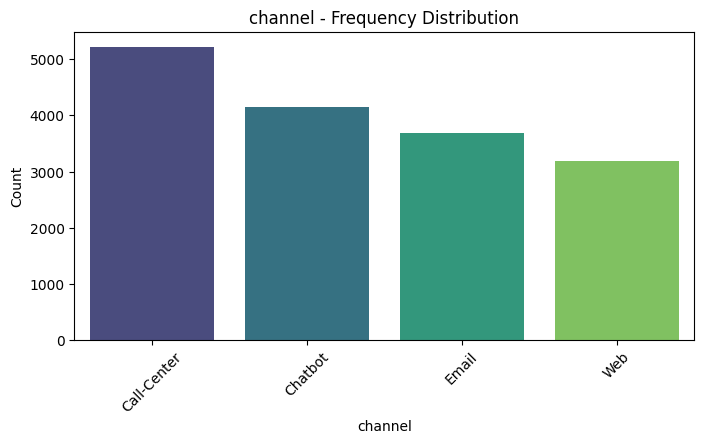

<ipython-input-222-02c7c91f24f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='viridis', order=dataset[col].value_counts().index)


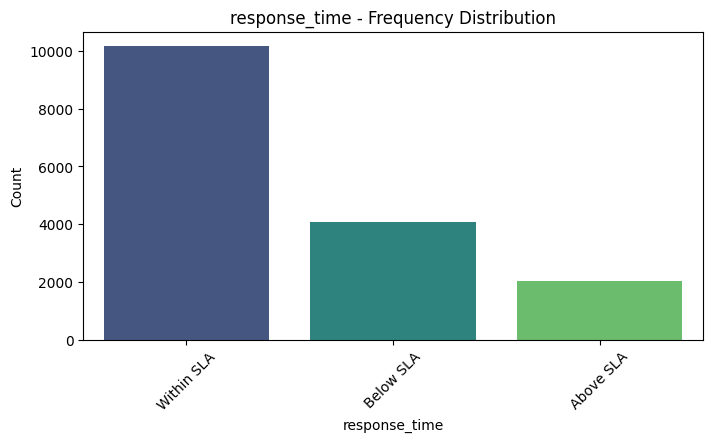

<ipython-input-222-02c7c91f24f6>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importances, palette='coolwarm')


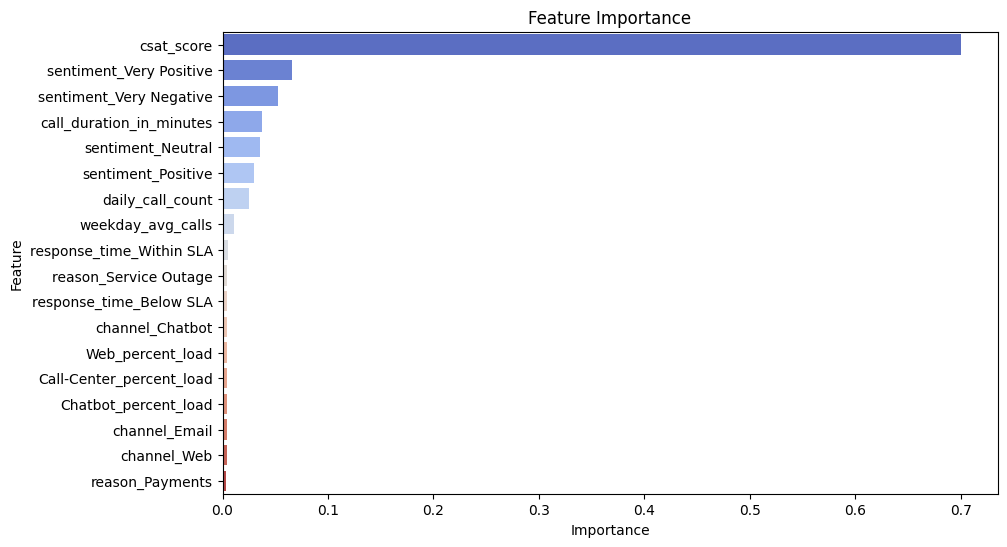

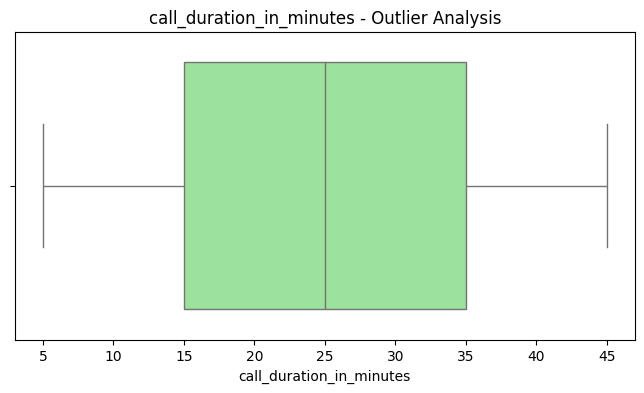

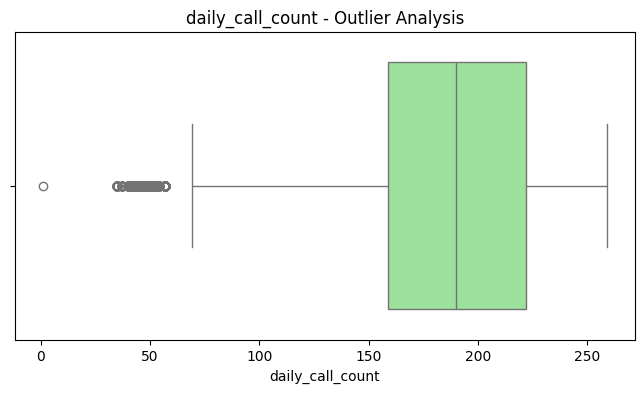

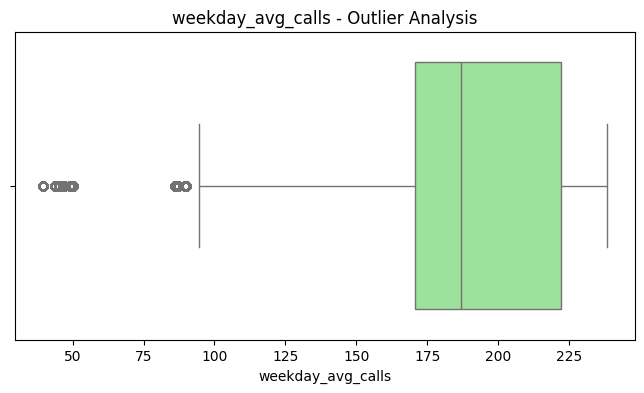

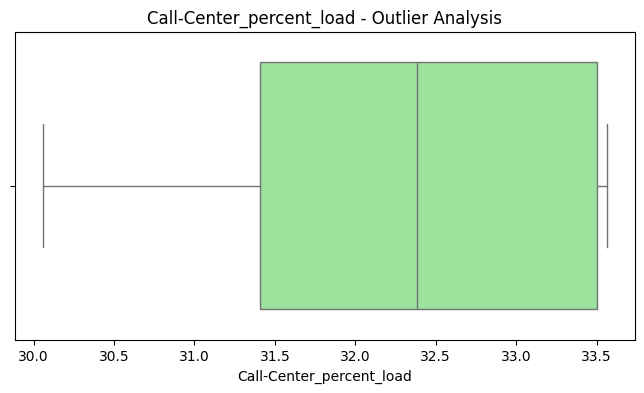

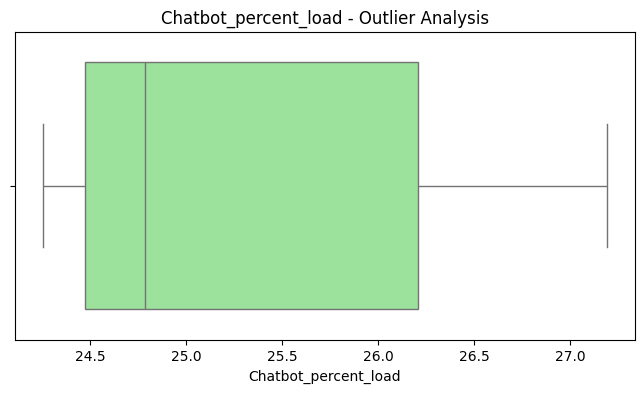

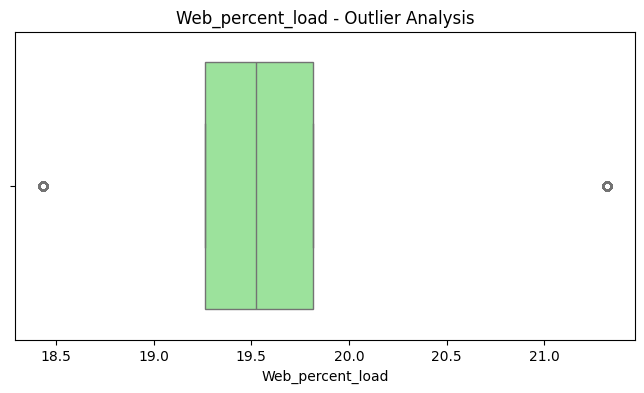

Missing Data (%):
sentiment                   0.0
csat_score                  0.0
reason                      0.0
channel                     0.0
response_time               0.0
call_duration_in_minutes    0.0
call_date                   0.0
daily_call_count            0.0
weekday_avg_calls           0.0
Call-Center_percent_load    0.0
Chatbot_percent_load        0.0
Web_percent_load            0.0
dtype: float64


In [226]:
numeric_columns = ["call_duration_in_minutes", "daily_call_count", "weekday_avg_calls", "Call-Center_percent_load", "Chatbot_percent_load", "Web_percent_load"]
categorical_columns = ["sentiment", "csat_score", "reason", "channel", "response_time"]

# Korelasyon analizi
plot_correlation_heatmap(dataset, numeric_columns)

# Varyans analizi
variances = calculate_variances(dataset, numeric_columns)

# Sayısal kolonların dağılımı
plot_numeric_distributions(dataset, numeric_columns)

# Kategorik kolonların dağılımı
plot_categorical_distributions(dataset, categorical_columns)

# Özellik önemi analizi (Hedef değişkeni belirtmeyi unutmayın!)
target_column = "csat_score"
feature_importances = calculate_feature_importance(dataset, numeric_columns, categorical_columns, target_column)

# Aykırı değer analizi
plot_outlier_analysis(dataset, numeric_columns)

# Eksik veri analizi
missing_data = calculate_missing_data(dataset)

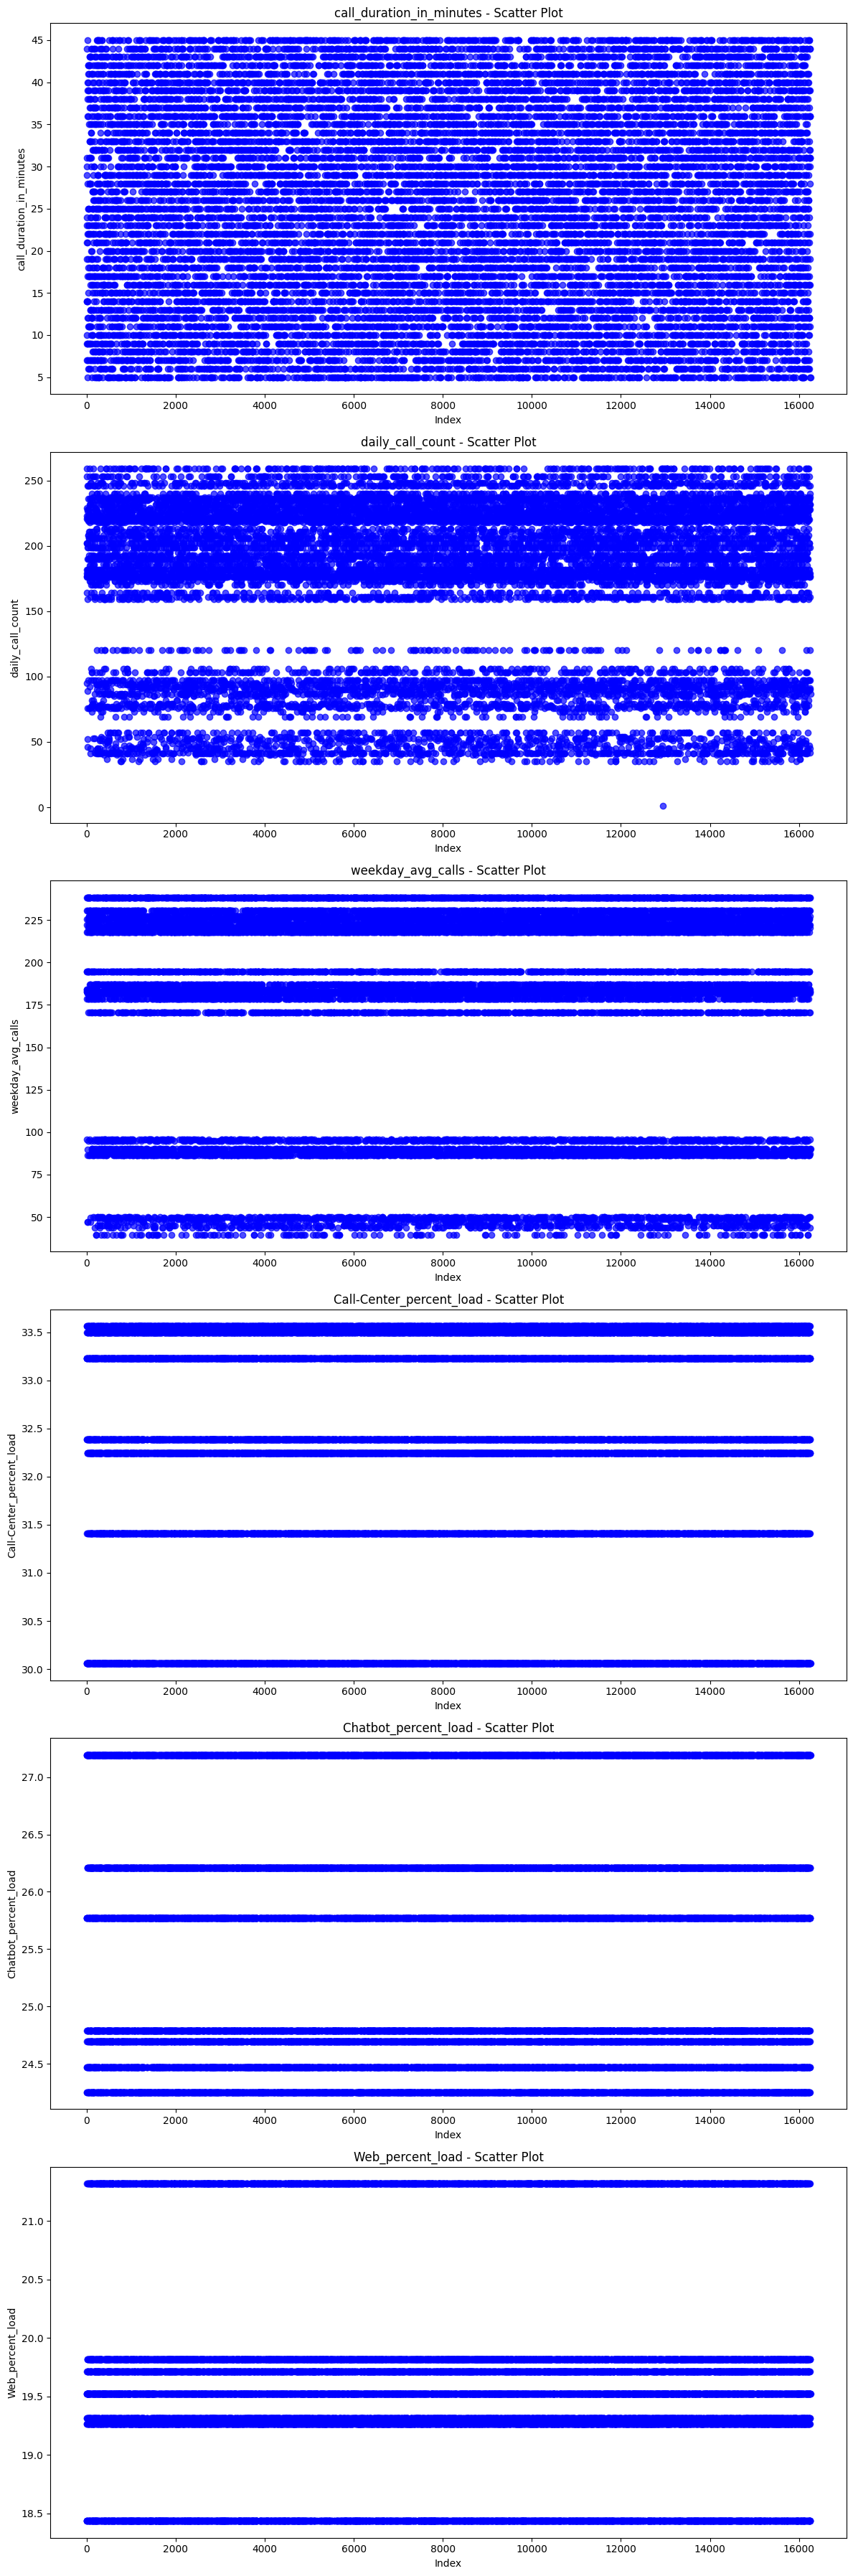

<ipython-input-227-fcd7c864e52e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='Set2')
<ipython-input-227-fcd7c864e52e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='Set2')
<ipython-input-227-fcd7c864e52e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette='Set2')
<ipython-input-227-fcd7c864e52e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False

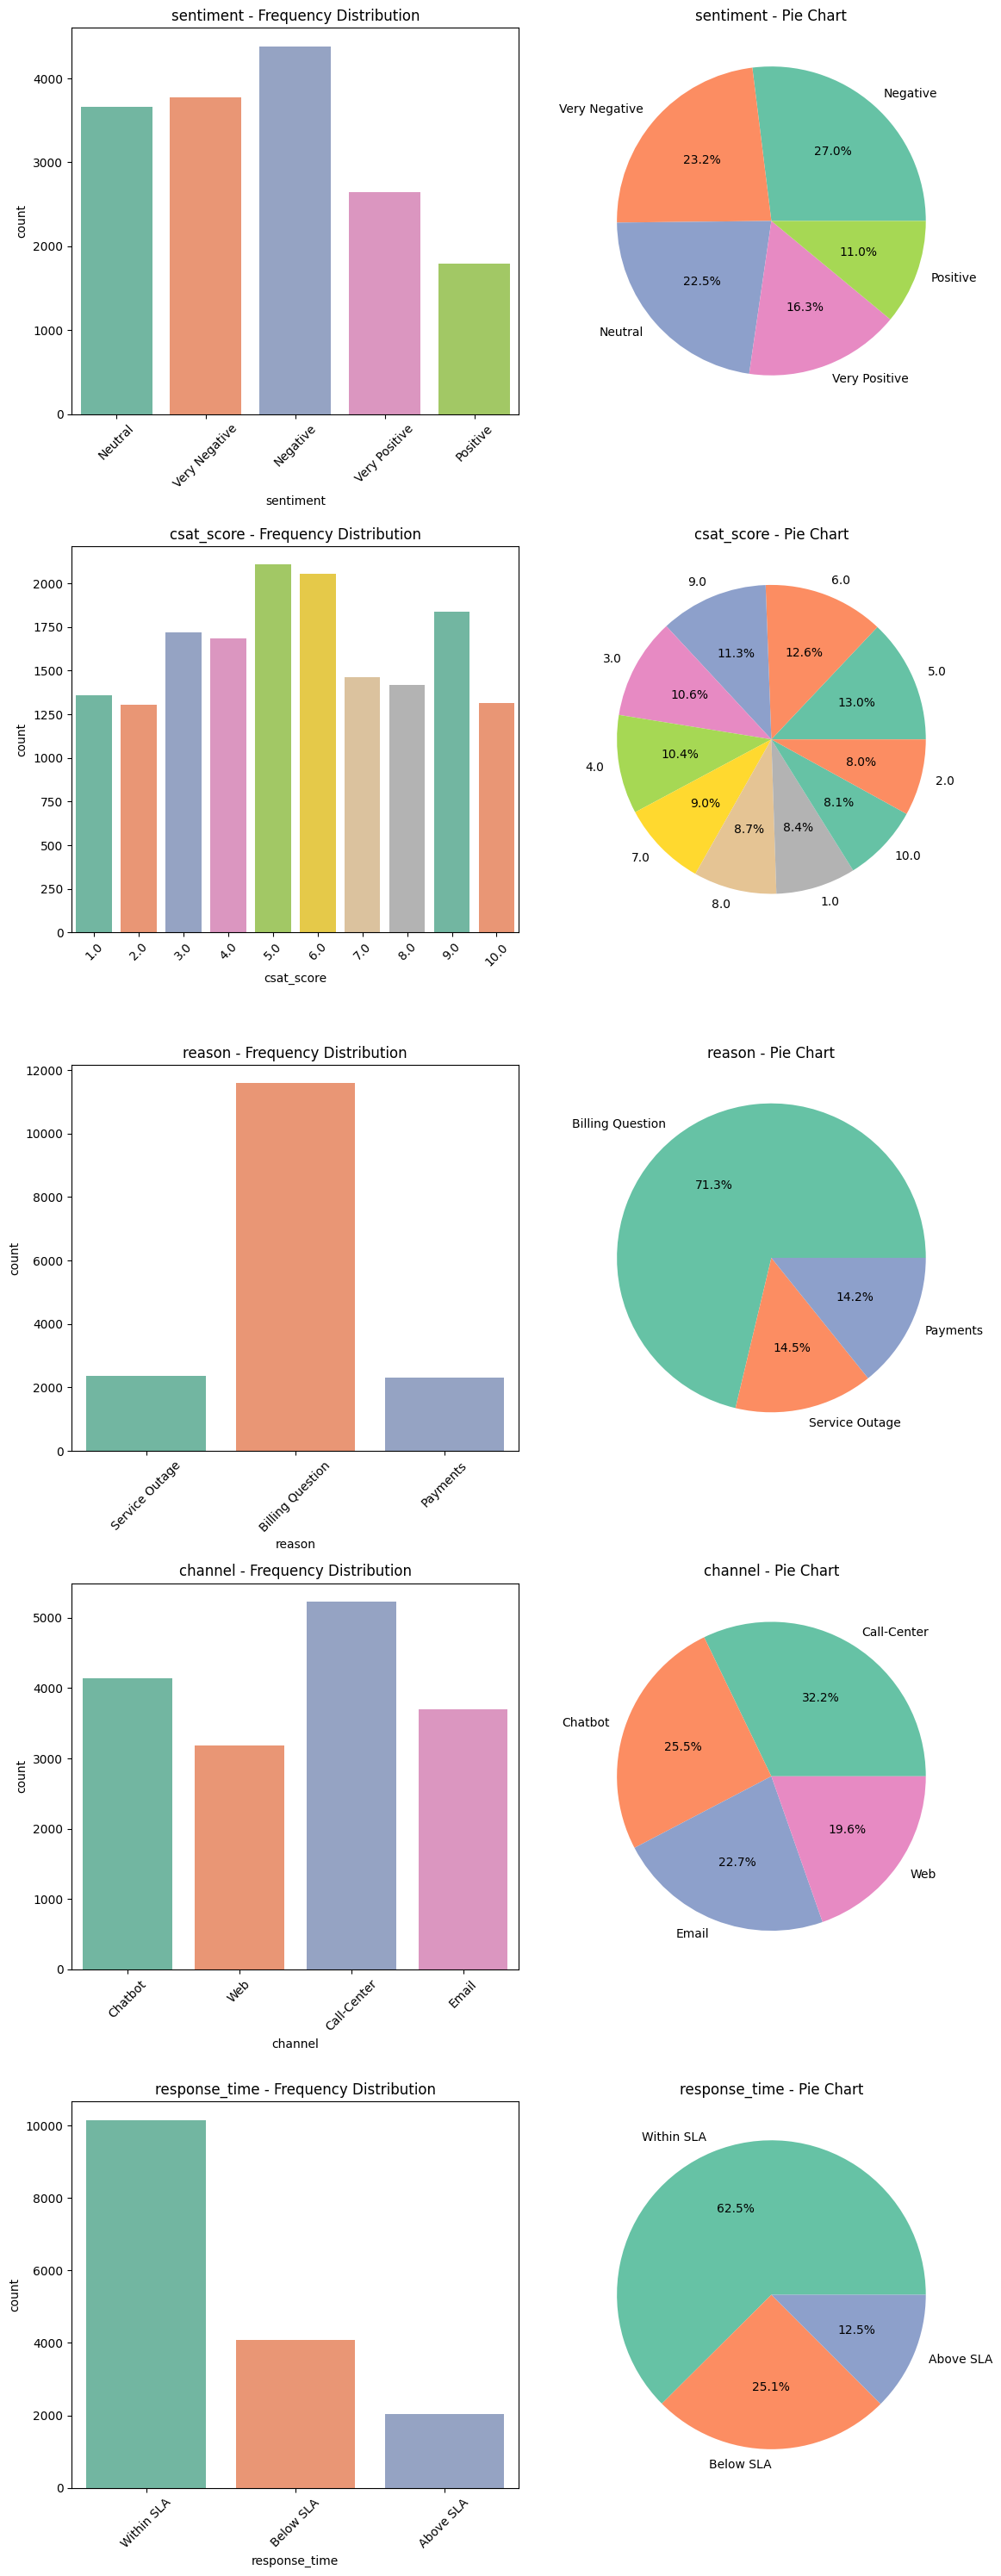

In [227]:
numeric_columns = ["call_duration_in_minutes", "daily_call_count", "weekday_avg_calls", "Call-Center_percent_load", "Chatbot_percent_load", "Web_percent_load"]
categorical_columns = ["sentiment", "csat_score", "reason", "channel", "response_time"]

def plot_numeric_distribution(dataset, numeric_columns):
    plt.figure(figsize=(12, 6 * len(numeric_columns)))

    for i, col in enumerate(numeric_columns, 1):
        # Scatter Plot for each numeric column against the index
        plt.subplot(len(numeric_columns), 1, i)
        plt.scatter(range(len(dataset[col])), dataset[col], alpha=0.7, color='blue')
        plt.title(f'{col} - Scatter Plot')
        plt.xlabel('Index')
        plt.ylabel(col)

    plt.tight_layout()
    plt.show()

def plot_categorical_distribution(dataset, categorical_columns):
    plt.figure(figsize=(12, 6 * len(categorical_columns)))
    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(len(categorical_columns), 2, 2*i-1)
        sns.countplot(x=dataset[col], palette='Set2')
        plt.title(f'{col} - Frequency Distribution')
        plt.xticks(rotation=45)

        plt.subplot(len(categorical_columns), 2, 2*i)
        dataset[col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set2', len(dataset[col].unique())))
        plt.title(f'{col} - Pie Chart')
        plt.ylabel('')
    plt.tight_layout()
    plt.show()



plot_numeric_distribution(dataset, numeric_columns)
plot_categorical_distribution(dataset, categorical_columns)

# Aykırı Değer (Outlier) Analizi

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

numeric_columns = ["call_duration_in_minutes",
                   "daily_call_count", "weekday_avg_calls",
                   "Call-Center_percent_load", "Chatbot_percent_load",
                   "Web_percent_load"]

def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

def calculate_outlier_ratio(data, column):
    outliers = detect_outliers(data, column)
    outlier_ratio = len(outliers) / len(data) * 100
    return outlier_ratio


for column in numeric_columns:
    outlier_count = len(detect_outliers(dataset, column))
    outlier_ratio = calculate_outlier_ratio(dataset, column)
    print(f"{column} Aşırı Değer Sayısı: {outlier_count}")
    print(f"{column} Aşırı Değer Oranı: {outlier_ratio:.2f}%")

print(dataset.describe())
print(dataset.info())

call_duration_in_minutes Aşırı Değer Sayısı: 0
call_duration_in_minutes Aşırı Değer Oranı: 0.00%
daily_call_count Aşırı Değer Sayısı: 1373
daily_call_count Aşırı Değer Oranı: 8.45%
weekday_avg_calls Aşırı Değer Sayısı: 3290
weekday_avg_calls Aşırı Değer Oranı: 20.24%
Call-Center_percent_load Aşırı Değer Sayısı: 0
Call-Center_percent_load Aşırı Değer Oranı: 0.00%
Chatbot_percent_load Aşırı Değer Sayısı: 0
Chatbot_percent_load Aşırı Değer Oranı: 0.00%
Web_percent_load Aşırı Değer Sayısı: 4272
Web_percent_load Aşırı Değer Oranı: 26.28%
         csat_score  call_duration_in_minutes                      call_date  \
count  16258.000000              16258.000000                          16258   
mean       5.535183                 25.113790  2020-10-15 13:31:29.678927104   
min        1.000000                  5.000000            2020-10-01 00:00:00   
25%        3.000000                 15.000000            2020-10-08 00:00:00   
50%        5.000000                 25.000000            2020

In [229]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

#kullanılması planlanmayan ya da zaten kullanılmış kolonlar
dataset = drop_unnecessary_columns(dataset, will_be_deleted_column_names=["call_date"])

""# Sonuçları kontrol et
print(dataset.describe())

# Ölçeklendirme için birer scaler nesnesi oluşturuyoruz
min_max_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

columns_with_outliers = ["daily_call_count", "weekday_avg_calls"]
columns_without_outliers = ["call_duration_in_minutes", "Call-Center_percent_load", "Chatbot_percent_load", "Web_percent_load"]

# Aykırı değerlere duyarlı kolonlar için RobustScaler kullanıyoruz
dataset[columns_with_outliers] = robust_scaler.fit_transform(dataset[columns_with_outliers])

# Aykırı değerlere duyarlı olmayan kolonlar için Min-Max veya StandardScaler kullanabilirsiniz
dataset[columns_without_outliers] = min_max_scaler.fit_transform(dataset[columns_without_outliers])


# Sonuçları kontrol et
print(dataset.describe())

         csat_score  call_duration_in_minutes  daily_call_count  \
count  16258.000000              16258.000000      16258.000000   
mean       5.535183                 25.113790        174.359331   
std        2.721137                 11.793218         62.312657   
min        1.000000                  5.000000          1.000000   
25%        3.000000                 15.000000        159.000000   
50%        5.000000                 25.000000        190.000000   
75%        8.000000                 35.000000        222.000000   
max       10.000000                 45.000000        259.000000   

       weekday_avg_calls  Call-Center_percent_load  Chatbot_percent_load  \
count       16258.000000              16258.000000          16258.000000   
mean          174.359331                 32.262580             25.438740   
std            61.109640                  1.220740              1.039316   
min            39.560510                 30.058362             24.254181   
25%           17

In [230]:
print(dataset.info())
print(dataset.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16258 entries, 0 to 16257
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sentiment                 16258 non-null  object 
 1   csat_score                16258 non-null  float64
 2   reason                    16258 non-null  object 
 3   channel                   16258 non-null  object 
 4   response_time             16258 non-null  object 
 5   call_duration_in_minutes  16258 non-null  float64
 6   daily_call_count          16258 non-null  float64
 7   weekday_avg_calls         16258 non-null  float64
 8   Call-Center_percent_load  16258 non-null  float64
 9   Chatbot_percent_load      16258 non-null  float64
 10  Web_percent_load          16258 non-null  float64
dtypes: float64(7), object(4)
memory usage: 1.4+ MB
None
Index(['sentiment', 'csat_score', 'reason', 'channel', 'response_time',
       'call_duration_in_minutes', 'daily_call_

In [231]:
for column in numeric_columns:
    outlier_count = len(detect_outliers(dataset, column))
    outlier_ratio = calculate_outlier_ratio(dataset, column)
    print(f"{column} Aşırı Değer Sayısı: {outlier_count}")
    print(f"{column} Aşırı Değer Oranı: {outlier_ratio:.2f}%")

call_duration_in_minutes Aşırı Değer Sayısı: 0
call_duration_in_minutes Aşırı Değer Oranı: 0.00%
daily_call_count Aşırı Değer Sayısı: 1373
daily_call_count Aşırı Değer Oranı: 8.45%
weekday_avg_calls Aşırı Değer Sayısı: 3290
weekday_avg_calls Aşırı Değer Oranı: 20.24%
Call-Center_percent_load Aşırı Değer Sayısı: 0
Call-Center_percent_load Aşırı Değer Oranı: 0.00%
Chatbot_percent_load Aşırı Değer Sayısı: 0
Chatbot_percent_load Aşırı Değer Oranı: 0.00%
Web_percent_load Aşırı Değer Sayısı: 4272
Web_percent_load Aşırı Değer Oranı: 26.28%


In [232]:
print(dataset.head(20).to_string())

dataset = drop_unnecessary_columns(dataset, will_be_deleted_column_names=["weekday_avg_calls"])

dataset = pd.get_dummies(dataset, columns=['reason', 'channel', 'response_time'])

print(dataset.head(20).to_string())

        sentiment  csat_score            reason      channel response_time  call_duration_in_minutes  daily_call_count  weekday_avg_calls  Call-Center_percent_load  Chatbot_percent_load  Web_percent_load
0         Neutral         7.0    Service Outage      Chatbot    Within SLA                     0.225         -0.126984          -0.079055                  0.000000              1.000000          0.378193
1         Neutral         6.0  Billing Question      Chatbot     Below SLA                     0.350         -0.206349          -0.056052                  0.905872              0.516336          0.000000
2         Neutral         5.0    Service Outage          Web    Within SLA                     0.050          0.492063           0.603713                  0.385391              0.150462          1.000000
3   Very Negative         1.0  Billing Question  Call-Center    Within SLA                     0.475         -0.222222          -0.056052                  0.905872              0.51633

In [233]:
numeric_columns = ["call_duration_in_minutes",
                   "daily_call_count",
                   "Call-Center_percent_load", "Chatbot_percent_load",
                   "Web_percent_load"]

for column in numeric_columns:
    outlier_count = len(detect_outliers(dataset, column))
    outlier_ratio = calculate_outlier_ratio(dataset, column)
    print(f"{column} Aşırı Değer Sayısı: {outlier_count}")
    print(f"{column} Aşırı Değer Oranı: {outlier_ratio:.2f}%")

call_duration_in_minutes Aşırı Değer Sayısı: 0
call_duration_in_minutes Aşırı Değer Oranı: 0.00%
daily_call_count Aşırı Değer Sayısı: 1373
daily_call_count Aşırı Değer Oranı: 8.45%
Call-Center_percent_load Aşırı Değer Sayısı: 0
Call-Center_percent_load Aşırı Değer Oranı: 0.00%
Chatbot_percent_load Aşırı Değer Sayısı: 0
Chatbot_percent_load Aşırı Değer Oranı: 0.00%
Web_percent_load Aşırı Değer Sayısı: 4272
Web_percent_load Aşırı Değer Oranı: 26.28%


In [234]:
dataset.to_csv('example.csv', index=False)

In [200]:
!pip install scikit-learn==1.2.2 xgboost --upgrade

In [235]:
print(dataset.info())
print(dataset.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16258 entries, 0 to 16257
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sentiment                 16258 non-null  object 
 1   csat_score                16258 non-null  float64
 2   call_duration_in_minutes  16258 non-null  float64
 3   daily_call_count          16258 non-null  float64
 4   Call-Center_percent_load  16258 non-null  float64
 5   Chatbot_percent_load      16258 non-null  float64
 6   Web_percent_load          16258 non-null  float64
 7   reason_Billing Question   16258 non-null  bool   
 8   reason_Payments           16258 non-null  bool   
 9   reason_Service Outage     16258 non-null  bool   
 10  channel_Call-Center       16258 non-null  bool   
 11  channel_Chatbot           16258 non-null  bool   
 12  channel_Email             16258 non-null  bool   
 13  channel_Web               16258 non-null  bool   
 14  respon

<ipython-input-236-a149917cfe08>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")


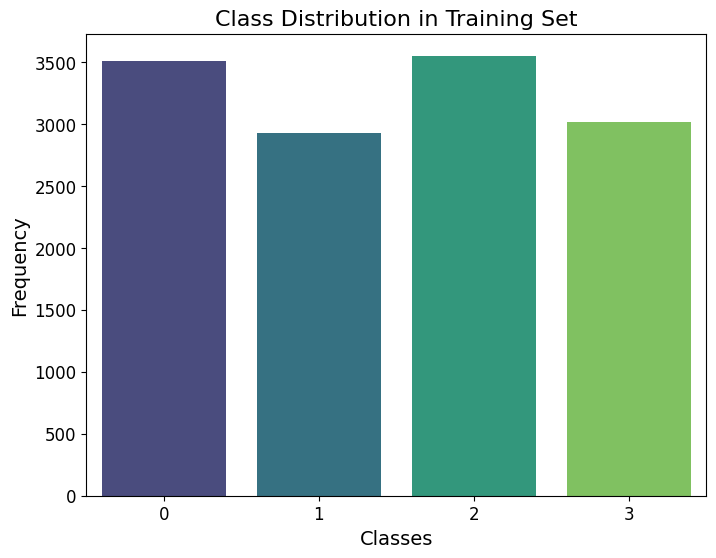

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Eğitim setindeki sınıf dağılımını görselleştirme
# y_train'in pandas Series formatında olduğundan emin olun
y_train_series = pd.Series(y_train)

class_distribution = y_train_series.value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Class Distribution in Training Set", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [238]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Örnek dataset tanımı (kendi dataset'inizi buraya yükleyin)
# dataset = pd.read_csv('your_dataset.csv')  # Kendi dosyanızı yükleyin

# Positive ve Very Positive etiketlerini birleştirme
dataset['sentiment'] = dataset['sentiment'].replace({'Very Positive': 'Positive'})

# Etiketlerin dağılımını kontrol etme
class_distribution = dataset['sentiment'].value_counts()
print("Class distribution before split:")
print(class_distribution)

# Hedef değişken ve özelliklerin ayrılması
X = dataset.drop(columns=['sentiment'])
y = dataset['sentiment']

# Hedef değişkenin sayısal kodlara dönüştürülmesi
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Etiket dönüşümlerini kontrol etme
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Sınıf Etiket Dönüşümü:", label_mapping)

# Eğitim ve test setine stratified split ile ayırma (dengeyi korumak için)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Eğitim ve test setlerindeki yeni dağılımları kontrol etme
train_class_distribution = pd.Series(y_train).value_counts()
test_class_distribution = pd.Series(y_test).value_counts()

print("\nTraining set class distribution:")
print(train_class_distribution)
print("\nTest set class distribution:")
print(test_class_distribution)

# Setleri CSV'ye kaydetme
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_train, columns=['sentiment']).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test, columns=['sentiment']).to_csv('y_test.csv', index=False)

print("\nVeri kümeleri CSV dosyalarına başarıyla kaydedildi.")


Class distribution before split:
sentiment
Positive         4438
Negative         4384
Very Negative    3773
Neutral          3663
Name: count, dtype: int64
Sınıf Etiket Dönüşümü: {'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Very Negative': 3}

Training set class distribution:
2    3550
0    3507
3    3018
1    2931
Name: count, dtype: int64

Test set class distribution:
2    888
0    877
3    755
1    732
Name: count, dtype: int64

Veri kümeleri CSV dosyalarına başarıyla kaydedildi.


# Eğitime Girecek Hedef Niteliğin (Sentiment) Dengeli Dağılımının Görselleştirilmesi

<ipython-input-239-a149917cfe08>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")


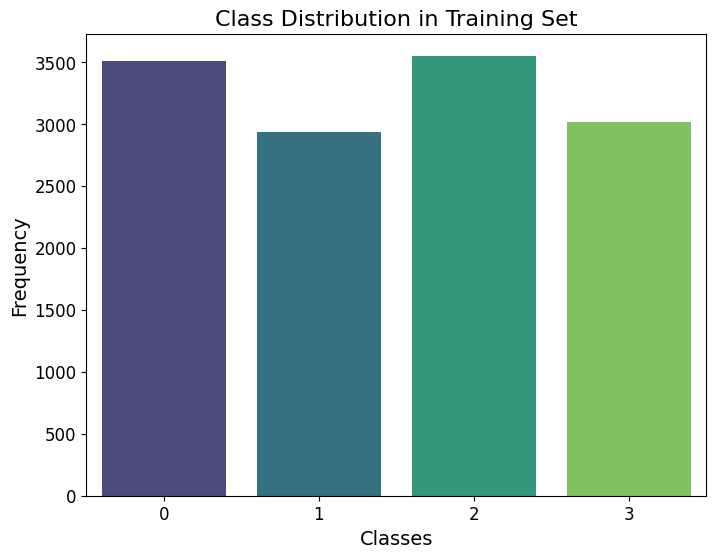

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Eğitim setindeki sınıf dağılımını görselleştirme
# y_train'in pandas Series formatında olduğundan emin olun
y_train_series = pd.Series(y_train)

class_distribution = y_train_series.value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Class Distribution in Training Set", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Hiper Parametre ile En Optimum Model ve Parametrelerin Belirlenmesi

In [204]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier


# Hiperparametre optimizasyonu için modeller ve parametre ızgaraları
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}

param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto']
    },
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "solver": ['lbfgs', 'liblinear'],
        "max_iter": [500, 1000]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 6],
        "min_child_weight": [1, 3]
    }
}

# Sonuçları saklamak için boş bir dict
results = {}

# K-Fold Cross Validation ile her modelin parametrelerini optimize et
for model_name in models:
    print(f"Optimizing {model_name}...")

    model = models[model_name]
    param_grid = param_grids[model_name]

    # GridSearchCV ile hiperparametre optimizasyonu
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=StratifiedKFold(n_splits=5),
                               scoring='accuracy', n_jobs=-1, verbose=1)

    # Modeli eğit
    grid_search.fit(X_train, y_train)

    # En iyi parametreleri ve skorları al
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Modelin test setindeki performansını al
    y_pred = grid_search.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Sonuçları sakla
    results[model_name] = {
        "best_params": best_params,
        "best_score": best_score,
        "test_accuracy": accuracy,
        "classification_report": classification_report(y_test, y_pred)
    }

# En iyi sonucu veren modeli bul
best_model = max(results, key=lambda x: results[x]['test_accuracy'])

# En iyi sonucu ve parametreleri yazdır
print(f"\nBest Model: {best_model}")
print("Best Parameters:", results[best_model]['best_params'])
print("Best Cross-validation Score:", results[best_model]['best_score'])
print("Test Accuracy:", results[best_model]['test_accuracy'])
print("\nClassification Report:\n", results[best_model]['classification_report'])


Optimizing Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimizing SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Optimizing Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Optimizing XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Model: XGBoost
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Best Cross-validation Score: 0.7220166606528973
Test Accuracy: 0.734009840098401

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.67       877
           1       0.54      0.80      0.65       733
           2       1.00      0.73      0.85       887
           3       1.00      0.70      0.82       755

    accuracy                           0.73      3252
   macro avg       0.79      0.74      0.75      3252
weighted avg       0.80      0.73      0.75  

# Kullanıcı Testi

In [ ]:
# En iyi model ve parametreleri al
best_params = results[best_model]["best_params"]

# En iyi modeli yeniden oluştur ve eğit
if best_model == "Random Forest":
    final_model = RandomForestClassifier(**best_params)
elif best_model == "SVM":
    final_model = SVC(**best_params)
elif best_model == "Logistic Regression":
    final_model = LogisticRegression(**best_params, max_iter=1000)
elif best_model == "XGBoost":
    final_model = XGBClassifier(**best_params, eval_metric='mlogloss')

# Eğitilmiş modeli kullanarak tahmin yap
final_predictions = final_model.predict(X_test)

# Test setinde tahmin sonuçlarını yazdır
print("Final Predictions on Test Data:", final_predictions)
